## Data challenge 

### 27th November 2019
### Tamara Huete Stauffer

The data provided belongs to the Visible Infrared Imaging Radiometer Suite (VIIRS) that is used to detect active fires in near real time at a 375 m resolution.
The data belongs to the period from 11-18 November 2019.

The aim is to study the VIIRS properties inside two areas of interest.

The analysis includes the following structure:
1. R libraries
2. VIIRS fire data
3. VIIRS metadata
4. Global fire data distribution
5. Fires in areas of interest
6. Quality filtering
7. Fire properties in Africa and South America (over 7 days)
    - I4 temperature
    - FRP and Biomass loss rate
8. Detection of fires per country (over 7 day period)
9. Detection of fires per country and surface (over 7 days)
10. Fire evolution by day and country
11. Detection of fires per terrestrial biome (over 7 days)
12. Summary of results

***This notebook uses the R kernel. To install follow instructions here: https://irkernel.github.io/installation/***

## 1. R libraries

In [1]:
# Load libraries
# to install any misisng packages execute: install.packages('package_name')
library(tidyverse) # load first, beacuse it masks some functions of other packages
library(rgdal) ## loads sp package automatically
library(rgeos)
library(raster)# for metadata/attributes- vectors or rasters
library(ggplot2)# figures
library(sf)
library(rnaturalearth) # for country boundary map
library(RColorBrewer) # get pretty palettes
library(geosphere) # for area calculations
library(repr) # adjust size of plots in the notebook

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: sp

rgdal: version: 1.4-4, (SVN revision 833)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.4.2, released 2019/06/28
 Path to GDAL shared files: /Library/Frameworks/R.framework/Versions/3.6/Resources/library/rgdal/gdal
 GDAL binary built with GEOS: FALSE 
 Loaded PROJ.4 runtime: Rel. 5.2.0, September 15th, 2018, [PJ_VERSION: 520]
 Path to PROJ.4 shared files: /Library/Frameworks/R.framework/Versions/3.6/Resources/library/rgdal/proj
 Linking to sp version: 1.3-1 

rgeos version: 0.5-1, (SVN revision 614)
 GEOS runtime version: 

## 2. VIIRS fire data

In [2]:
# create temporaty file to download zip and delete temporary file
temp <- tempfile()
download.file("https://firms.modaps.eosdis.nasa.gov/active_fire/viirs/shapes/zips/VNP14IMGTDL_NRT_Global_7d.zip",temp)
VIIRS <- unzip(temp)
unlink(temp)

# check the files in the unzipped folder
#VIIRS

# load the shp file
fire  <- readOGR(dsn = "VNP14IMGTDL_NRT_Global_7d")

OGR data source with driver: ESRI Shapefile 
Source: "/Users/huetestm/Documents/Vizzuality/VNP14IMGTDL_NRT_Global_7d", layer: "VNP14IMGTDL_NRT_Global_7d"
with 309896 features
It has 13 fields


In [3]:
class(fire)

crs(fire) # get the coordinate reference system
# reference system is WGS84
# proj = latlong (geographic reference system, not projected) 
# Units are decimal degrees
# EPSG =4326

extent(fire) # see the polygon extension that includes all points
# the coordinates show that the extension of the shp is nearly global (long -180:180 and lat -53:72)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

CRS arguments:
 +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0 

class      : Extent 
xmin       : -175.0729 
xmax       : 179.6046 
ymin       : -53.18082 
ymax       : 72.23299 

In [4]:
head(fire)

LATITUDE,LONGITUDE,BRIGHT_TI4,SCAN,TRACK,ACQ_DATE,ACQ_TIME,SATELLITE,CONFIDENCE,VERSION,BRIGHT_TI5,FRP,DAYNIGHT
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>
-27.10763,19.76041,303.4,0.50,0.49,2019/11/11,0018,N,nominal,1.0NRT,287.0,0.0,N
-27.89504,23.59476,296.7,0.44,0.62,2019/11/11,0018,N,nominal,1.0NRT,284.5,0.4,N
-28.21237,23.55256,297.3,0.44,0.62,2019/11/11,0018,N,nominal,1.0NRT,284.9,1.4,N
-28.36073,23.51417,322.4,0.44,0.62,2019/11/11,0018,N,nominal,1.0NRT,286.6,2.3,N
-28.36039,23.50952,299.0,0.44,0.62,2019/11/11,0018,N,nominal,1.0NRT,284.7,2.3,N
-33.99226,22.42217,297.1,0.42,0.61,2019/11/11,0018,N,nominal,1.0NRT,286.2,0.9,N


## 3. VIIRS metadata
From https://earthdata.nasa.gov/earth-observation-data/near-real-time/firms/viirs-i-band-active-fire-data

Important variables for the study include:
 - BRIGHT_TI4 (VIIRS I-4 channel brightness): temperature of the fire pixel measured in Kelvin (mid infrared)
 - CONFIDENCE : low, nominal, high
 - BRIGHT_TI5 (VIIRS I-5 channel brightness): temperature of the fire pixel measured in Kelvin (long infrared)
 - FRP (Fire Radiative Power) pixel-integrated in MW (megawatts) (Fire radiative power)
 - ACQ_DATE (Adquisition date)

## 4. Global fire data distribution

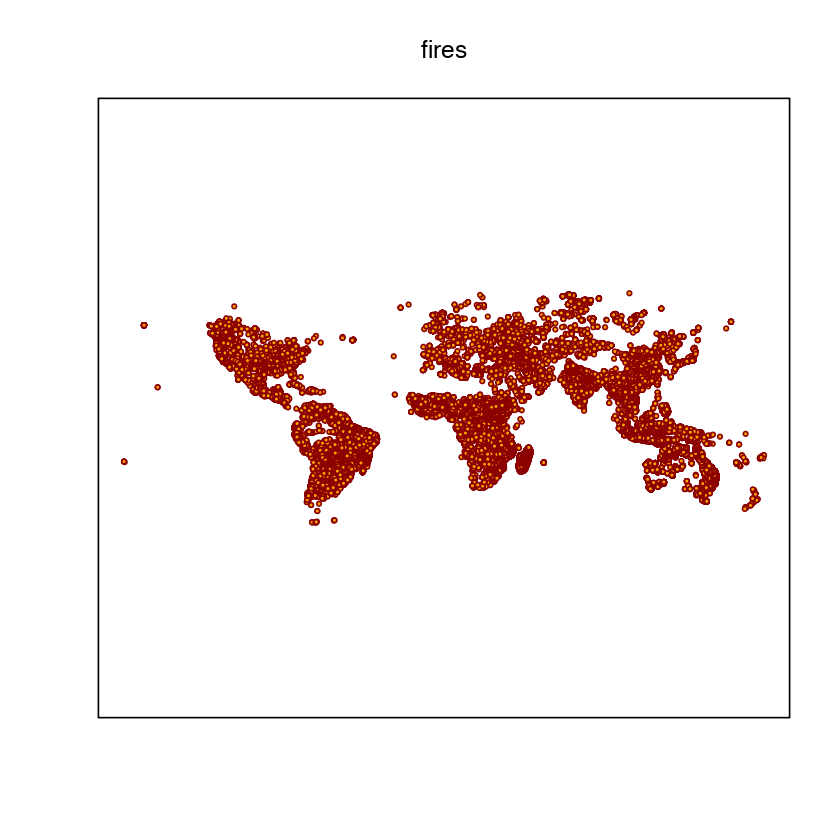

In [5]:
### Make a first exploratory figure of the points
plot(fire, col = "darkred",
     pch = 21,bg="orange",cex=0.4)
title("fires")
box()
### Each datapoint represents the location of an active fire
### The database is global

### - Overlay points over a global map

In [6]:
# create temporaty file to download zip and delete temporary file
temp <- tempfile()
download.file("http://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/physical/ne_110m_land.zip",temp)
land <- unzip(temp)
unlink(temp)

# check the files in the unzipped folder
#land

# load the shp file
world <- readOGR("ne_110m_land.shp")

OGR data source with driver: ESRI Shapefile 
Source: "/Users/huetestm/Documents/Vizzuality/ne_110m_land.shp", layer: "ne_110m_land"
with 127 features
It has 3 fields


Regions defined for each Polygons



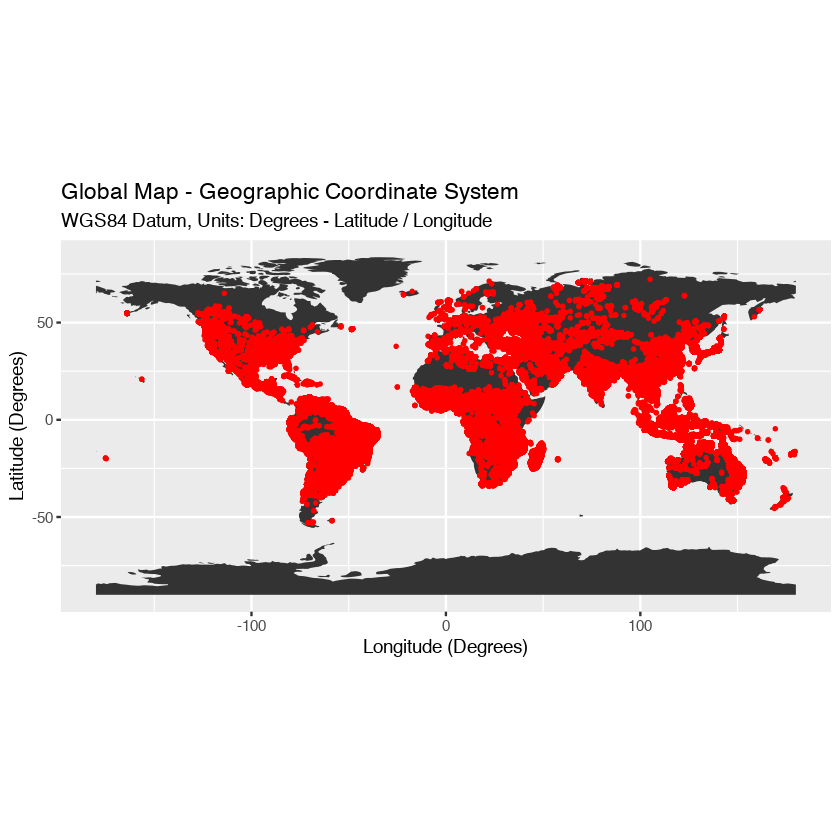

In [7]:
# convert to dataframe
world_df <- fortify(world)

# create base World map
worldMap <- ggplot(world_df, aes(long,lat, group = group)) +
  geom_polygon() +
  coord_equal() +
  labs(x = "Longitude (Degrees)",
       y = "Latitude (Degrees)",
      title = "Global Map - Geographic Coordinate System",
      subtitle = "WGS84 Datum, Units: Degrees - Latitude / Longitude")
  
# plot fires points over base World map
worldMap + geom_point(data=fire@data,aes(x=LONGITUDE,y=LATITUDE,group=NULL),col='red',fill="orange",size=0.5)

## 5. Fires in areas of interest

In [8]:
# Get areas of interest (areas.geojson)
areas <- readOGR(dsn = "https://raw.githubusercontent.com/tamaramegan/VIIRS_fire_detection/master/areas.geojson")

# check coordinate reference system
crs(areas) ## same as fire 

OGR data source with driver: GeoJSON 
Source: "https://raw.githubusercontent.com/tamaramegan/VIIRS_fire_detection/master/areas.geojson", layer: "areas"
with 2 features
It has 0 fields


CRS arguments:
 +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0 

### - Overlay fires over the areas of interest

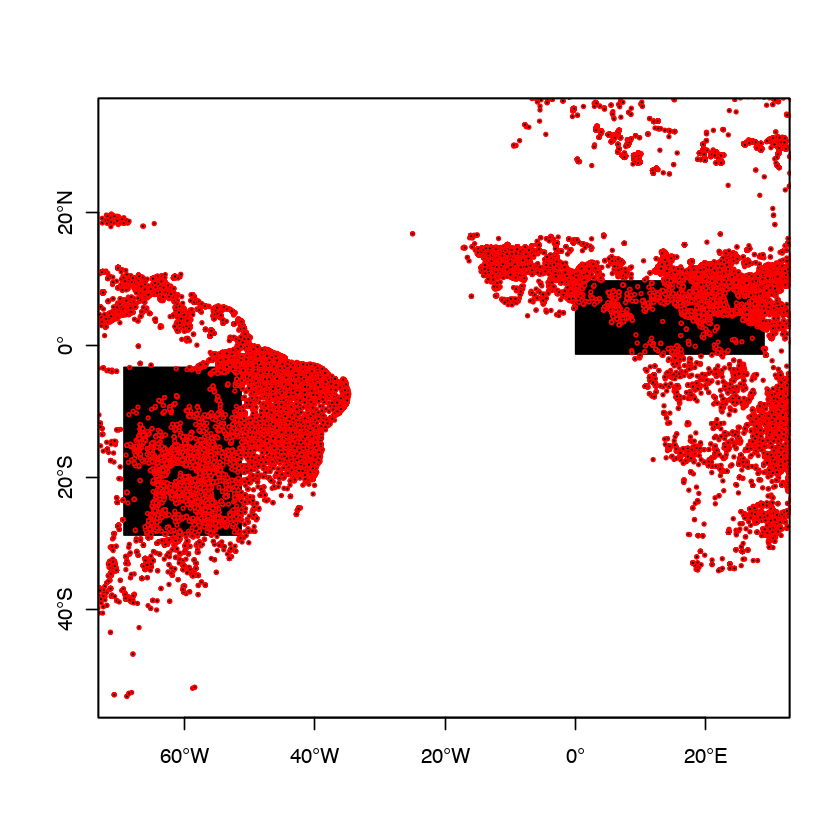

In [9]:
# plot areas and fire to see where the areas fall in global map
plot(areas, col= "black", axes=TRUE)
plot(fire, add=TRUE, pch=21, col="red",cex=0.3)
box()
## The areas of interest are in South America and Africa

### - Select only the fires that fall in the areas of interest

In [10]:
# which points fall inside the polygons
inside  <- over(fire,as(areas,"SpatialPolygons"))

# see the classification
unique(inside) #polygons 1, 2 or neither (NA)

# create new column with the polygon classification
fire@data$poly  <- inside 

# delete NA values (outside of polygons)
fire.pol = fire[!is.na(over(fire,as(areas,"SpatialPolygons"))),] 

# check results
head(fire.pol)
length(fire.pol) # 25448 fires (from original 309896)

[1] NA  2  1

,LATITUDE,LONGITUDE,BRIGHT_TI4,SCAN,TRACK,ACQ_DATE,ACQ_TIME,SATELLITE,CONFIDENCE,VERSION,BRIGHT_TI5,FRP,DAYNIGHT,poly
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<int>
434,9.69534,28.38891,329.0,0.57,0.52,2019/11/11,0006,N,nominal,1.0NRT,289.6,3.3,N,2
435,9.69629,28.38371,309.0,0.57,0.52,2019/11/11,0006,N,nominal,1.0NRT,288.8,3.2,N,2
471,9.63897,25.65905,300.1,0.57,0.43,2019/11/11,0006,N,nominal,1.0NRT,288.5,0.7,N,2
472,9.66081,25.50947,301.1,0.56,0.43,2019/11/11,0006,N,nominal,1.0NRT,287.6,0.9,N,2
473,9.62099,25.64487,310.6,0.57,0.43,2019/11/11,0006,N,nominal,1.0NRT,292.3,2.2,N,2
474,9.62006,25.65016,315.0,0.57,0.43,2019/11/11,0006,N,nominal,1.0NRT,291.4,2.2,N,2


[1] 25448

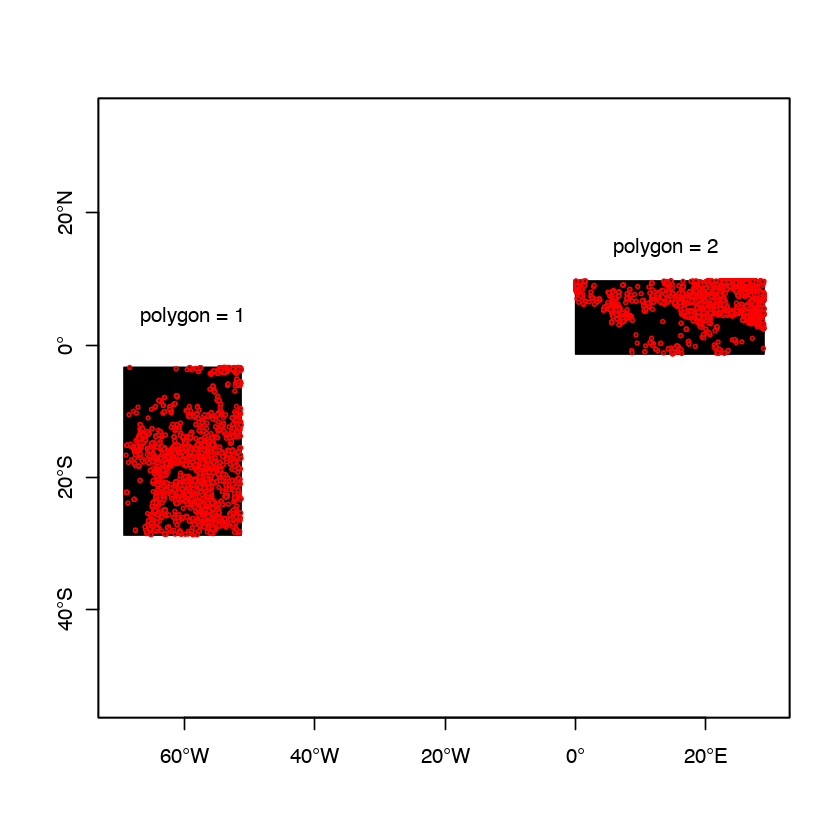

In [11]:
# Check that the selected fires fall inside the polygons
plot(areas, col= "black", axes=TRUE);
plot(fire.pol, add=TRUE, pch=21, col="red",cex=0.3);
box();
text(x= c(mean(fire.pol[fire.pol$poly==1,]$LONGITUDE), mean(fire.pol[fire.pol$poly==2,]$LONGITUDE)),
     y= c(max(fire.pol[fire.pol$poly==1,]$LATITUDE+5), max(fire.pol[fire.pol$poly==2,]$LATITUDE+5)), 
     label=c("polygon = 1", "polygon = 2"),pos=c(3,2))
# polygon 1 is South America
# polygon 2 is Africa

### - See fires in global map

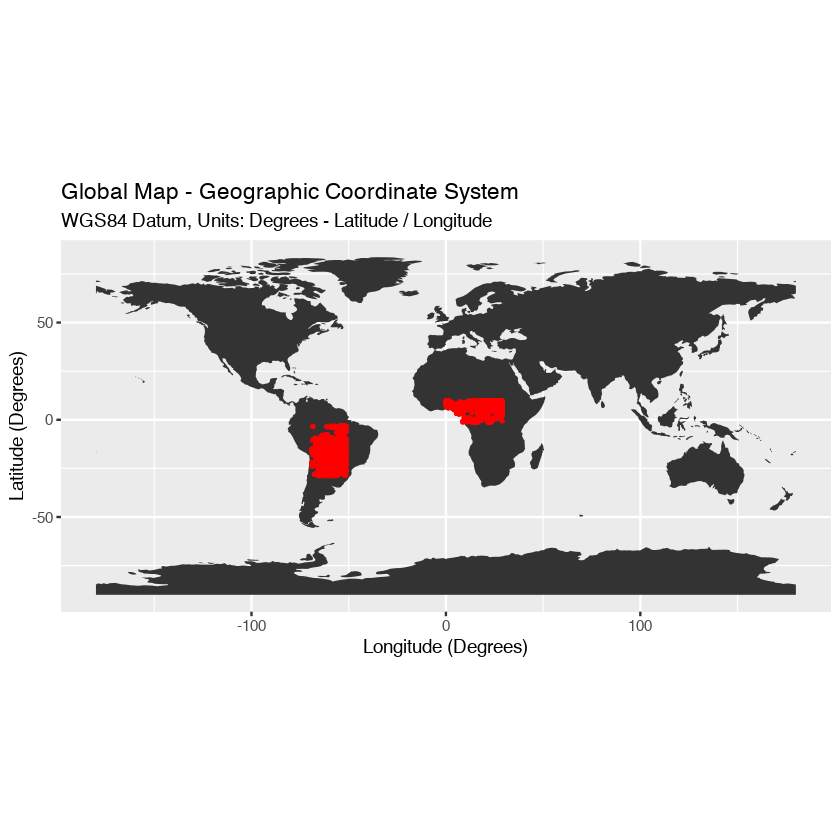

In [12]:
## plot fires of selected areas over map
worldMap + 
geom_point(data=fire.pol@data,aes(x=LONGITUDE,y=LATITUDE,group=NULL),col='red',size=0.5)

## 6. Quality filtering
 
The CONFIDENCE variable gives the quality rating of each fire. It already has been corrected for the South Atlantic magnetic anomaly, which would affect the area of South America. It has also been corrected for sun glint, cloud cover, etc.

Each fire is classified as'high', 'nominal' or 'low'. Removal of low quality data will ensure more accurate results

In [13]:
# find points labelled as low quality
low  <- which(fire.pol$CONFIDENCE =='low')

# remove low quality points 
fire.pol.q  <- fire.pol[-low,] ## keep only high and nominal confidence data

## 7. Fire properties in Africa and South America (over 7 days)
The most relevant fire properties include channel I4, I5 and FRP.

According to the VIIRS documentation (https://viirsland.gsfc.nasa.gov/PDF/VIIRS_activefire_375m_ATBD.pdf), cool fires have a range between 400 - 800 K (smoldering phases of combustion) while active fires have a range 800 - 1200 K (intense flaming phase). I4 (mid-infrared channel) is used for fire detection and I5 (long infrared, that includes cloud classification) is used to resolve conflicts when I4 is anomalously high.

The Fire Radiant Power (MW) is calculated from 750 m data and helps discriminate fires form noise in channel I4 and detect fires at subpixel level. In addition, FRP can be also used to calculate the biomass consumed per unit time.

### - I4 temperature

In [14]:
# covert kelvin to Celsius just to check values
fire.pol$I4_C <- fire.pol$BRIGHT_TI4-273.15
#range(fire.pol$I4_C)
#range(fire.pol$BRIGHT_TI4)

fire.pol$I5_C <- fire.pol$BRIGHT_TI5-273.15
#range(fire.pol$I5_C)
#range(fire.pol$BRIGHT_TI5)

# some fires in I5 are below zero, despite quality correction
# I4 is the channel preferred for fire detection


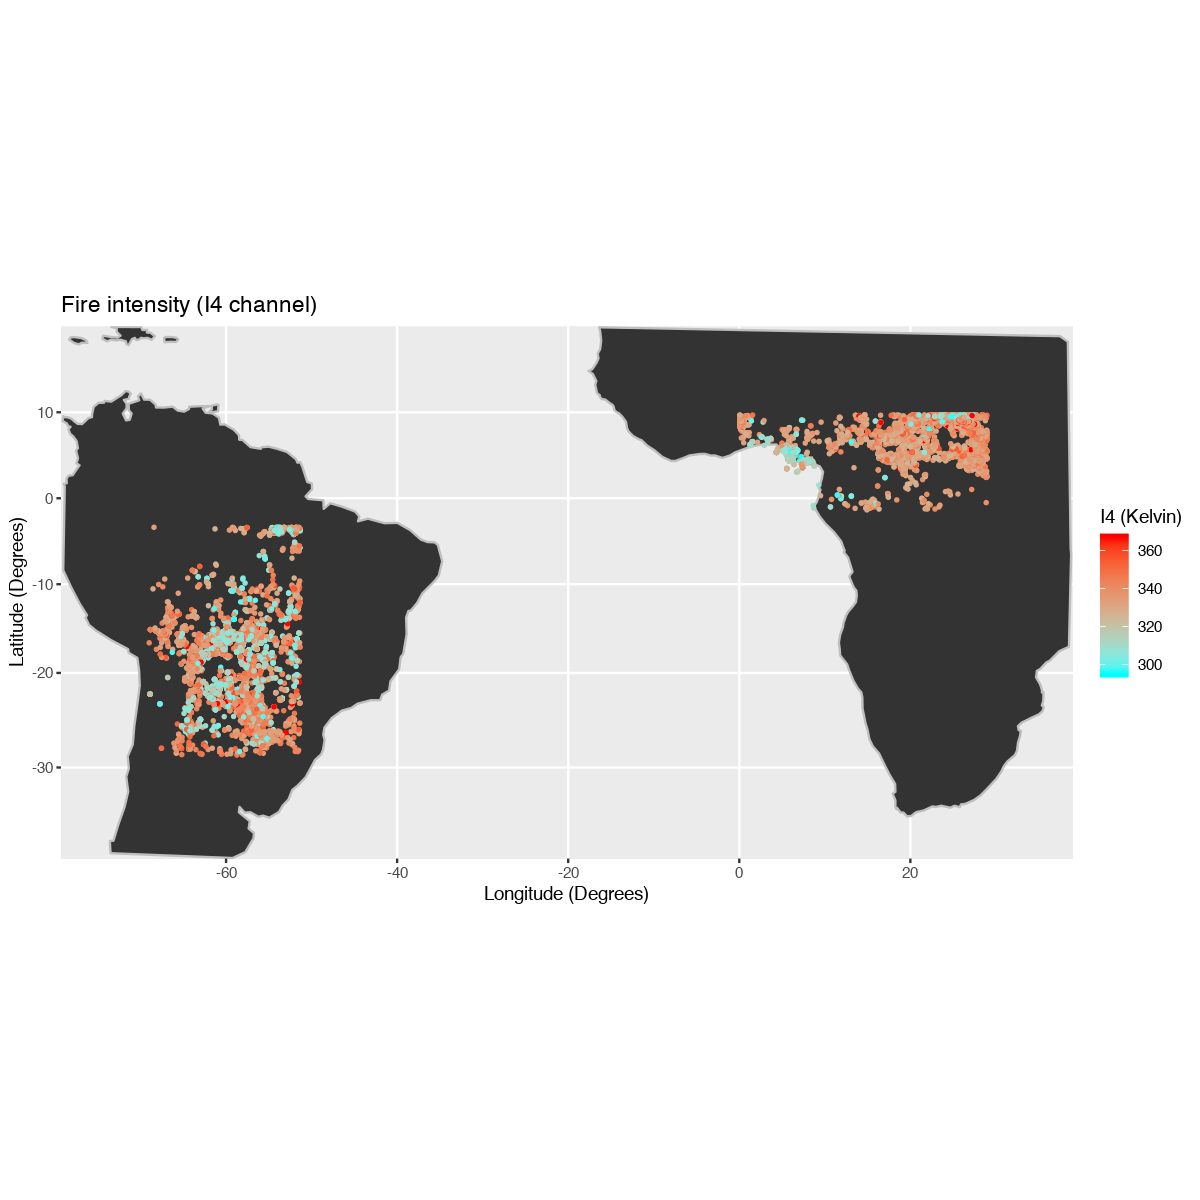

In [15]:
## restrict world map to the area of interest
# subset according to areas extension
small  <- subset(world_df,long > extent(areas)@xmin-10 & long < extent(areas)@xmax+10 &
                          lat > extent(areas)@ymin-10 & lat < extent(areas)@ymax+10)

# create map of the subsets
smallMap <- ggplot(small, aes(long,lat, group=group)) +
  geom_polygon(col="gray") +
  coord_map(xlim=c(extent(areas)@xmin-10, extent(areas)@xmax+10),
            ylim=c(extent(areas)@ymin-10, extent(areas)@ymax+10))

#VIIRS I4 channel
#BRIGHT_TI4 (Kelvin)
#I4_C (Celsius)
options(repr.plot.width=10, repr.plot.height=10)
smallMap + 
geom_point(data=fire.pol.q@data,aes(x=LONGITUDE,y=LATITUDE,group=NULL,color=BRIGHT_TI4),size=0.5) +
scale_color_gradient(low = "cyan", high = "red",
  space = "Lab", na.value = "grey50", guide = "colourbar",
  aesthetics = "colour")+
borders("world", xlim = c(-130, -60), ylim = c(20, 50))+
labs(x = "Longitude (Degrees)",
     y = "Latitude (Degrees)",
     title = "Fire intensity (I4 channel)",
     color = "I4 (Kelvin)")

# Fire are below 400K, most are probably small fires (subpixel detection) or in an advanced cooling stage

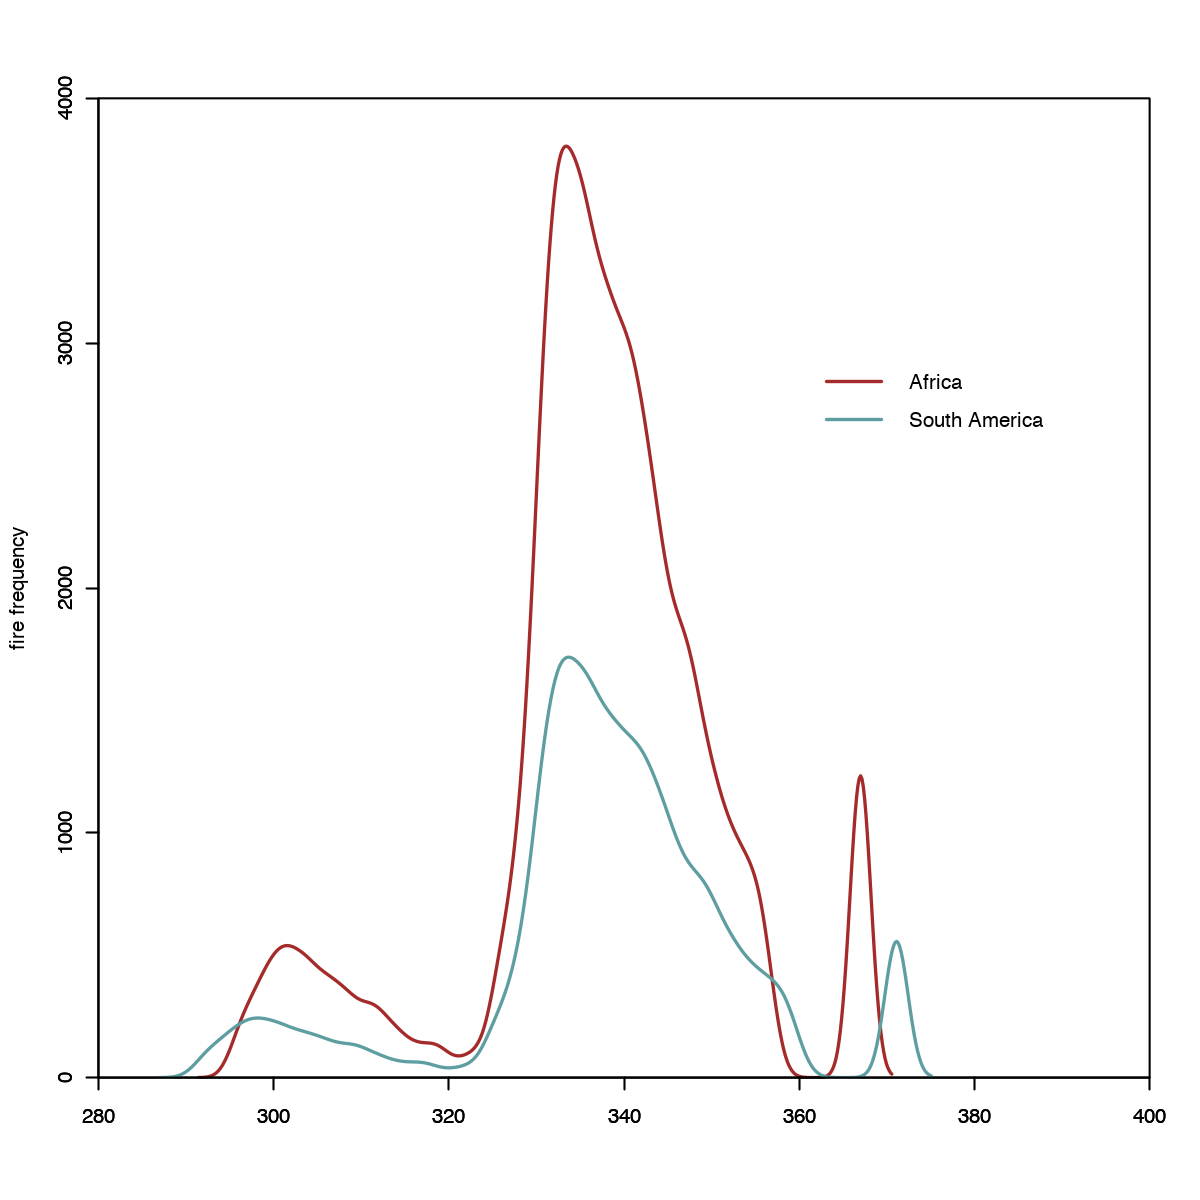

In [16]:
### Compare temperature distributions
#Africa
histAf <- hist(fire.pol.q[fire.pol.q$poly==2,]$BRIGHT_TI4,plot=FALSE)
multiplierAf <- histAf$counts / histAf$density
#South America
histSA <- hist(fire.pol.q[fire.pol.q$poly==1,]$BRIGHT_TI4,plot=FALSE)
multiplierSA <- histSA$counts / histSA$density

plot(x=density(fire.pol.q[fire.pol.q$poly==2,]$BRIGHT_TI4)$x,
      y=density(fire.pol.q[fire.pol.q$poly==2,]$BRIGHT_TI4)$y*multiplierAf[1],
      col='brown', main="", xlim=c(280,400), ylim=c(0,4000), 
      xlab="",ylab="fire frequency",xaxs='i', yaxs='i', lwd=2,type="l") #Africa
par(new=TRUE)
plot(x=density(fire.pol.q[fire.pol.q$poly==1,]$BRIGHT_TI4)$x,
     y=density(fire.pol.q[fire.pol.q$poly==2,]$BRIGHT_TI4)$y*multiplierSA[1],
     col='cadetblue', main="", xlim=c(280,400), ylim=c(0,4000), 
     xlab="",ylab="",xaxs='i', yaxs='i', lwd=2,type="l") #South America
legend(x=360, y= 3000, c('Africa','South America'), col=c('brown','cadetblue'), bty='n', lty=1, lwd=2)

# None of the fires appear to be in the active flaming phase (>1000 K)
# The detected fires seem to be in an advanced cooling phase (normally 400- 800K),
# but they can also be small active fires detected at subpixel level.
# There are more fires in Africa

In [17]:
### ANOVA of temperature
bright  <- aov(fire.pol.q$BRIGHT_TI4 ~ as.factor(fire.pol.q$poly))
summary(bright)
TukeyHSD(bright)
# the fires detected in Africa have 4K higher average temperature than in South America (p < 0.05)

                              Df  Sum Sq Mean Sq F value Pr(>F)    
as.factor(fire.pol.q$poly)     1   81586   81586     350 <2e-16 ***
Residuals                  23365 5446086     233                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = fire.pol.q$BRIGHT_TI4 ~ as.factor(fire.pol.q$poly))

$`as.factor(fire.pol.q$poly)`
        diff      lwr      upr p adj
2-1 4.036635 3.613732 4.459537     0


### - FRP and biomass loss rate
An estimation of the biomass loss rate can be made from the fire radiative power (FRP).
Woster et al. 2005 published a good agreement between the FRP (in kW) and mass loss rate (kg s-1): https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2005JD006318

[1] 4

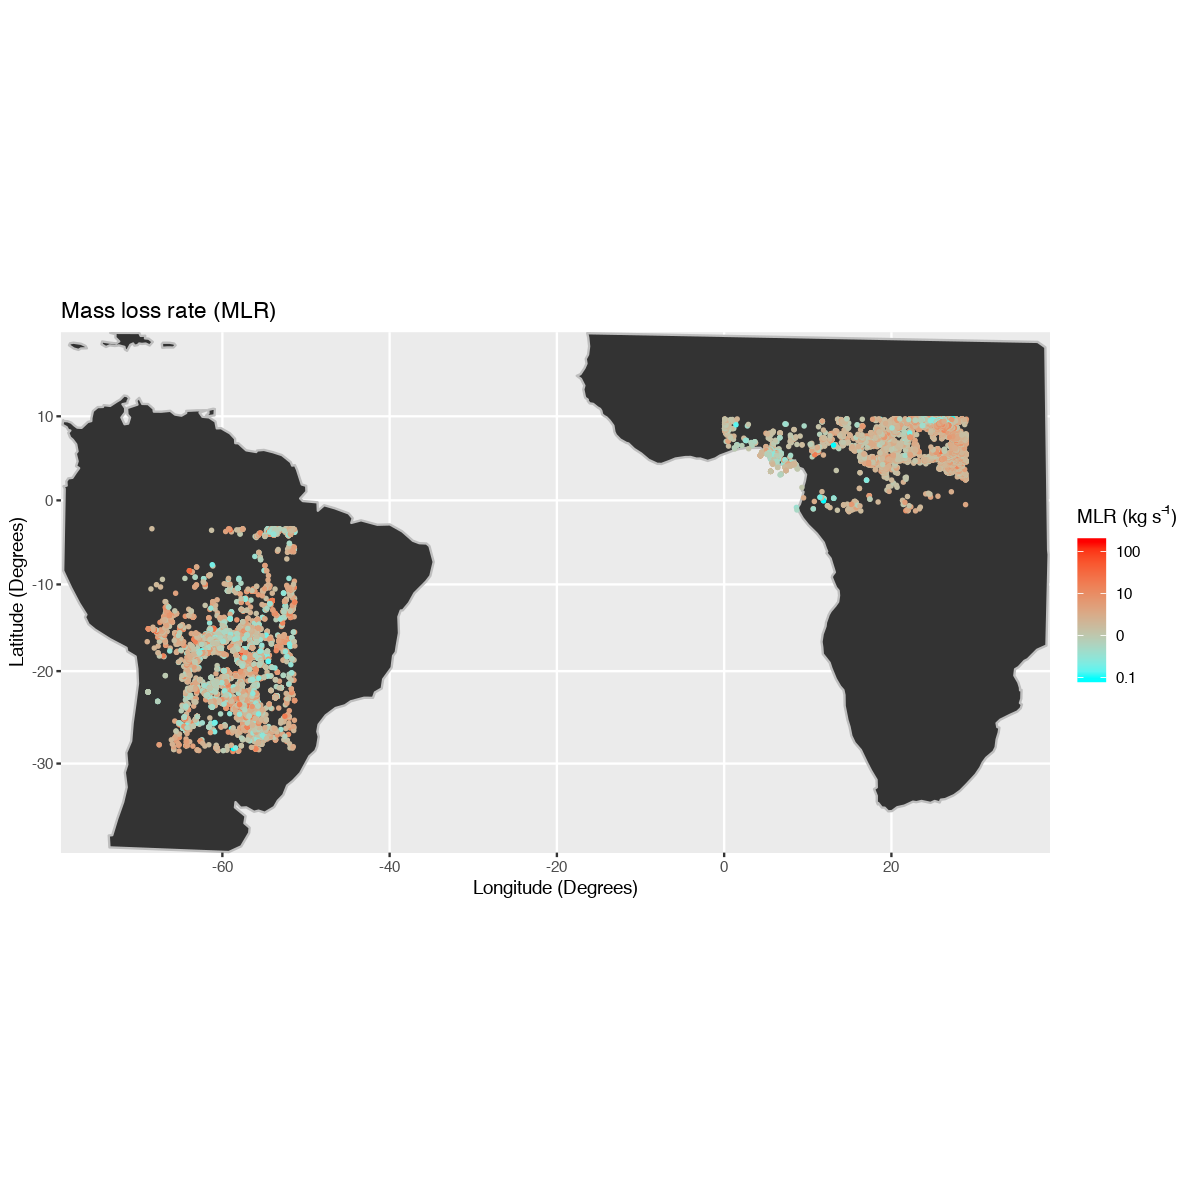

In [18]:
# mass loss rate (MLR)
# from Woster et al. 2005 
# MLR in kg s-1, FRP in kW
fire.pol.q@data$MLR = 0.464*10^-3*(fire.pol.q@data$FRP*1000)

# Average mass loss rate is 4 kg s-1
round(mean(fire.pol.q@data$MLR)) #4 ± 6 kg s-1
#round(sd(fire.pol.q@data$MLR))
#range(fire.pol.q@data$MLR) #0.0928-172.5

smallMap + 
geom_point(data=fire.pol.q@data,aes(x=LONGITUDE,y=LATITUDE,group=NULL,color=log(MLR)),size=0.5) +
scale_color_gradient(low = "cyan", high = "red",
  space = "Lab", na.value = "grey50", guide = "colourbar",
  aesthetics = "colour", breaks=c(-2.30, 0, 2.30, 4.6), labels=c(0.1,0,10,100))+
labs(x = "Longitude (Degrees)",
     y = "Latitude (Degrees)",
     title = "Mass loss rate (MLR)",
     color = expression(paste("MLR (kg ",s^-1,")")))
#color in log scale to be able to see differneces (most data are around 4 kg s-1)


In [19]:
### Compare Mass loss rate in Africa and South America
loss  <- aov(fire.pol.q$MLR ~ as.factor(fire.pol.q$poly))
summary(loss)
TukeyHSD(loss)
### the bimass loss rate per fire is 0.8 kg s-1 higher in South America (p < 0.05)
### FRP varies with type of fuel, material, humidity

                              Df Sum Sq Mean Sq F value Pr(>F)    
as.factor(fire.pol.q$poly)     1   3246    3246   93.68 <2e-16 ***
Residuals                  23365 809599      35                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = fire.pol.q$MLR ~ as.factor(fire.pol.q$poly))

$`as.factor(fire.pol.q$poly)`
          diff        lwr        upr p adj
2-1 -0.8051569 -0.9682115 -0.6421024     0


## 8. Detection of fires per country (over 7 day period)

In [20]:
# count fires in each area
fire.pol.q[fire.pol.q$poly==1,] %>% nrow() # 7267 fires in South America
fire.pol.q[fire.pol.q$poly==2,] %>% nrow() #16100 fires in Africa

[1] 7267

[1] 16100

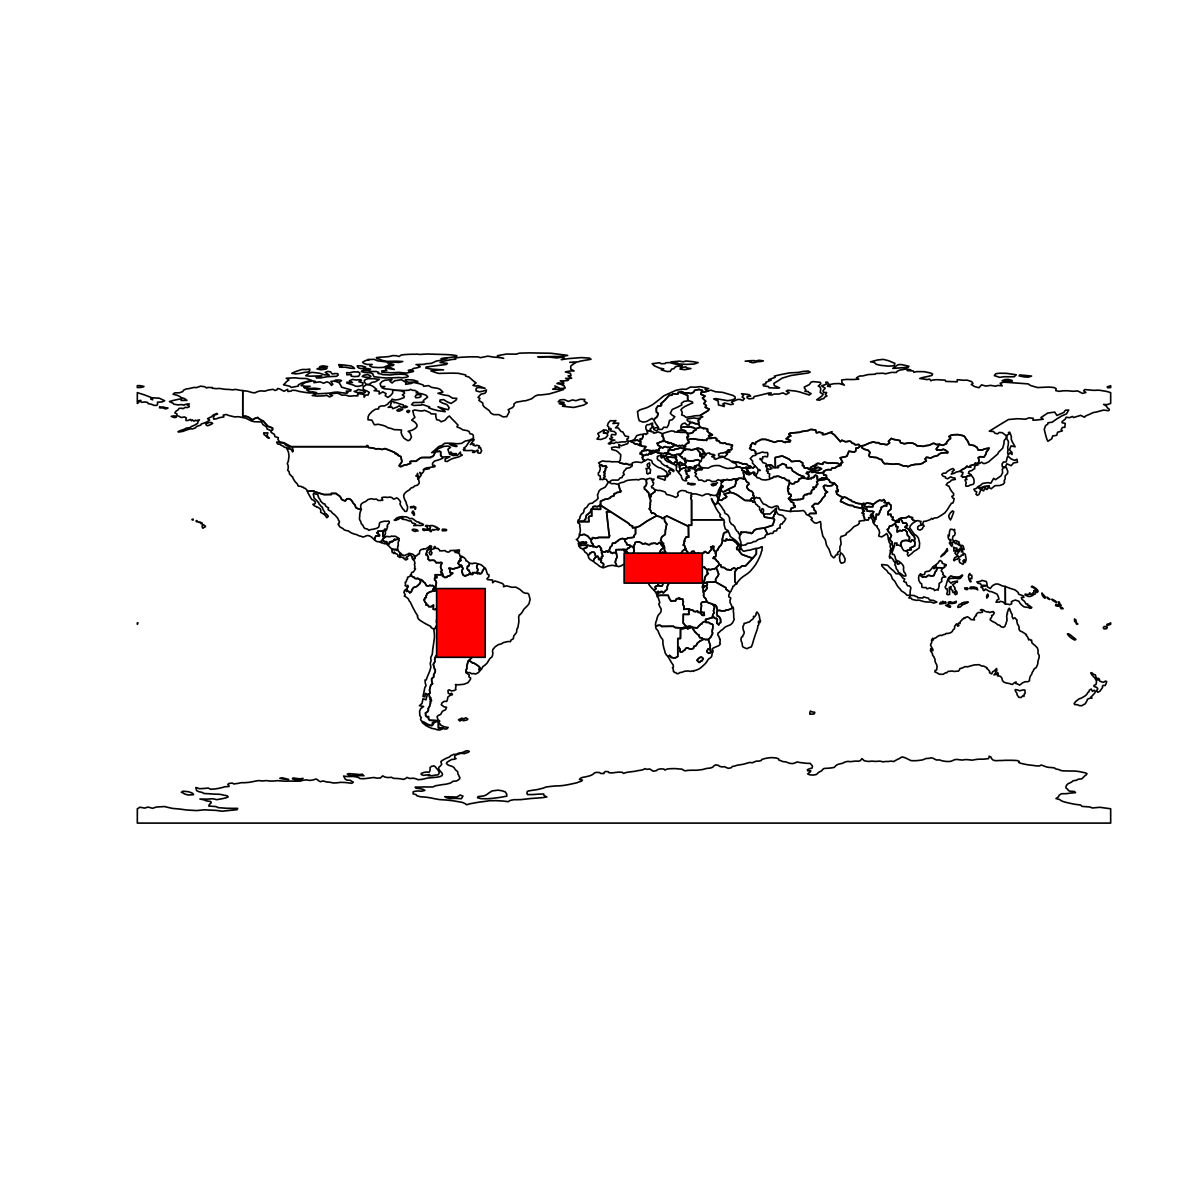

In [21]:
# Overlay Africa and South America areas to country boundaries
country_world <- ne_countries()
plot(country_world)
plot(areas, add=TRUE, col="red")

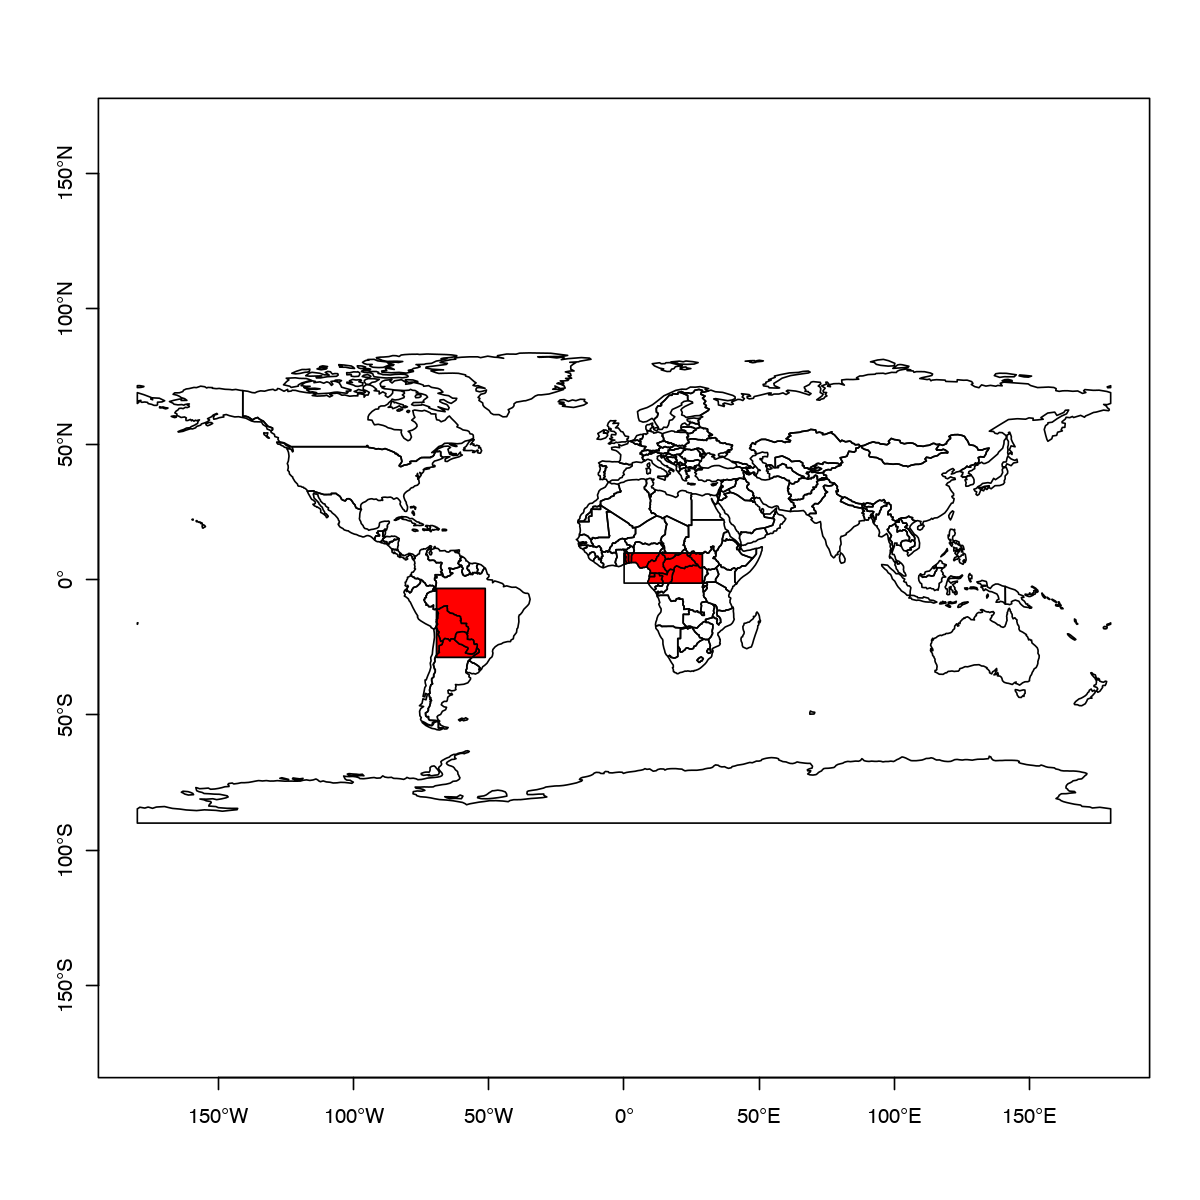

In [22]:
### Cross areas and country
areas.country <- intersect(country_world, areas)
plot(country_world, axes=T); plot(areas, add=T); plot(areas.country, add=T, col='red')

In [23]:
head(areas.country)
nrow(areas.country) #the areas of interest are spread over 19 countries 

scalerank,featurecla,labelrank,sovereignt,sov_a3,adm0_dif,level,type,admin,adm0_a3,⋯,continent,region_un,subregion,region_wb,name_len,long_len,abbrev_len,tiny,homepart,FID
<int>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,Admin-0 country,2,Argentina,ARG,0,2,Sovereign country,Argentina,ARG,⋯,South America,Americas,South America,Latin America & Caribbean,9,9,4,NA,1,0
1,Admin-0 country,5,Benin,BEN,0,2,Sovereign country,Benin,BEN,⋯,Africa,Africa,Western Africa,Sub-Saharan Africa,5,5,5,NA,1,1
1,Admin-0 country,3,Bolivia,BOL,0,2,Sovereign country,Bolivia,BOL,⋯,South America,Americas,South America,Latin America & Caribbean,7,7,7,NA,1,0
1,Admin-0 country,2,Brazil,BRA,0,2,Sovereign country,Brazil,BRA,⋯,South America,Americas,South America,Latin America & Caribbean,6,6,6,NA,1,0
1,Admin-0 country,4,Central African Republic,CAF,0,2,Sovereign country,Central African Republic,CAF,⋯,Africa,Africa,Middle Africa,Sub-Saharan Africa,20,24,6,NA,1,1
1,Admin-0 country,2,Chile,CHL,0,2,Sovereign country,Chile,CHL,⋯,South America,Americas,South America,Latin America & Caribbean,5,5,5,NA,1,0


[1] 19

In [24]:
### cross fire points with the new areas
fire.country  <- intersect(fire.pol.q,areas.country)
head(fire.country)
nrow(fire.country) #23163 (less beacuse some points fall in sea)

,LATITUDE,LONGITUDE,BRIGHT_TI4,SCAN,TRACK,ACQ_DATE,ACQ_TIME,SATELLITE,CONFIDENCE,VERSION,⋯,continent,region_un,subregion,region_wb,name_len,long_len,abbrev_len,tiny,homepart,FID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
434,9.69534,28.38891,329.0,0.57,0.52,2019/11/11,0006,N,nominal,1.0NRT,⋯,Africa,Africa,Northern Africa,Sub-Saharan Africa,5,5,5,NA,1,1
435,9.69629,28.38371,309.0,0.57,0.52,2019/11/11,0006,N,nominal,1.0NRT,⋯,Africa,Africa,Northern Africa,Sub-Saharan Africa,5,5,5,NA,1,1
471,9.63897,25.65905,300.1,0.57,0.43,2019/11/11,0006,N,nominal,1.0NRT,⋯,Africa,Africa,Eastern Africa,Sub-Saharan Africa,8,11,7,NA,1,1
472,9.66081,25.50947,301.1,0.56,0.43,2019/11/11,0006,N,nominal,1.0NRT,⋯,Africa,Africa,Eastern Africa,Sub-Saharan Africa,8,11,7,NA,1,1
473,9.62099,25.64487,310.6,0.57,0.43,2019/11/11,0006,N,nominal,1.0NRT,⋯,Africa,Africa,Eastern Africa,Sub-Saharan Africa,8,11,7,NA,1,1
474,9.62006,25.65016,315.0,0.57,0.43,2019/11/11,0006,N,nominal,1.0NRT,⋯,Africa,Africa,Eastern Africa,Sub-Saharan Africa,8,11,7,NA,1,1


[1] 23163

In [25]:
### Get the number of fires for each country
areas.country@data$n.fires  <- rep(0,nrow(areas.country))
for (i in unique(areas.country$sovereignt)){
   areas.country@data[areas.country@data$sovereignt==i,]$n.fires  <- nrow(fire.country[fire.country$sovereignt==i,])
   }

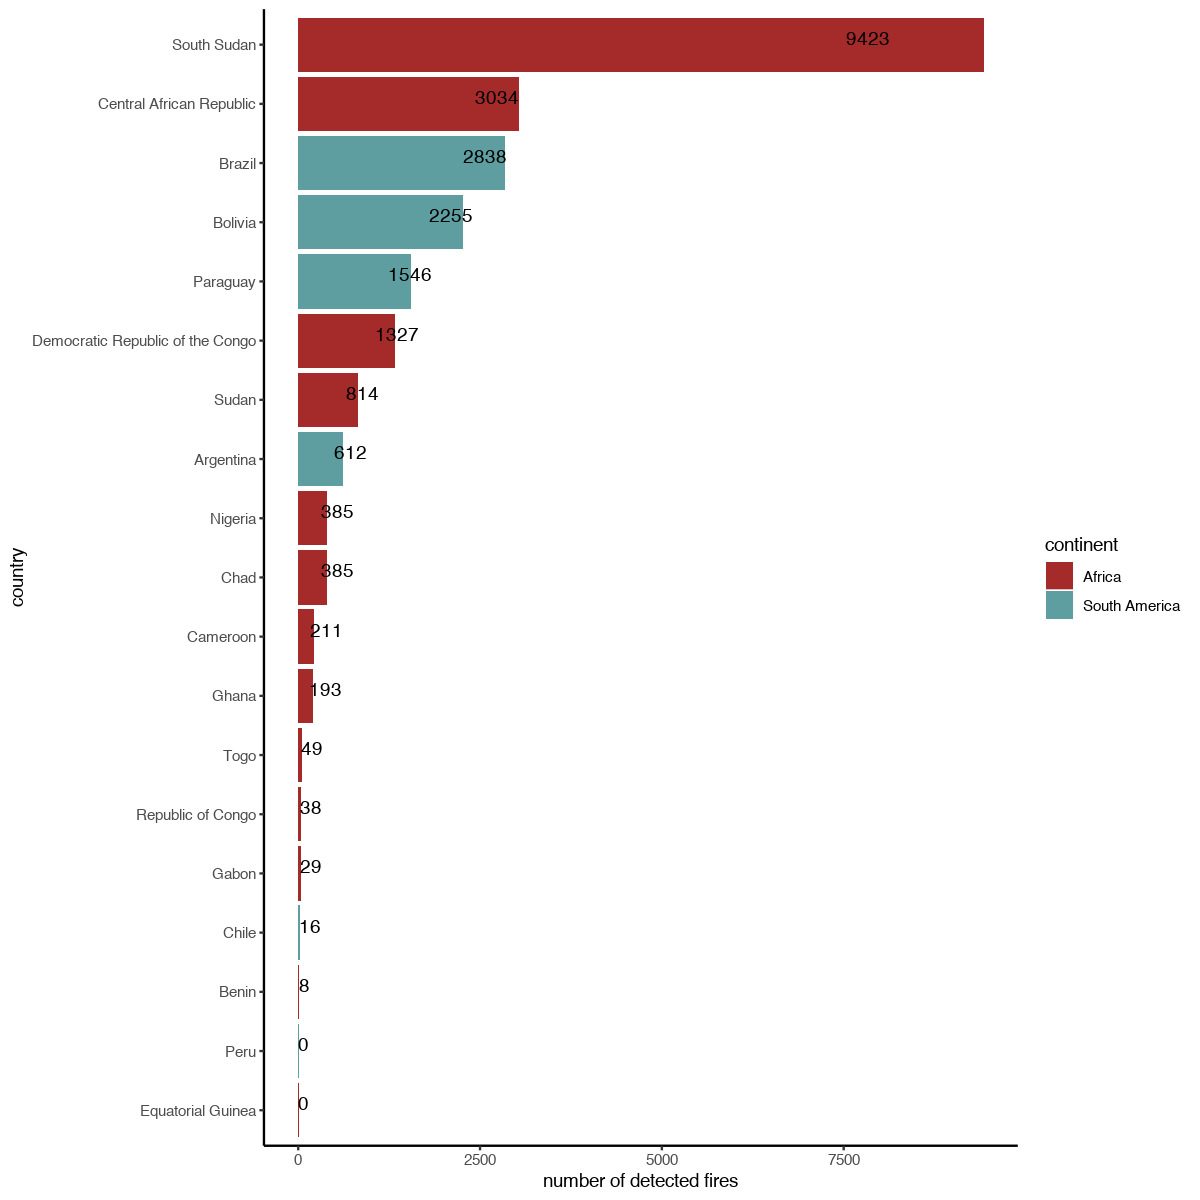

In [26]:
ggplot(data=areas.country@data, aes(x=reorder(sovereignt,n.fires), y = n.fires, fill=continent)) +
    geom_bar(stat='identity') + 
    coord_flip()+
    ylab('number of detected fires')+
    xlab('country')+
    geom_text(aes(y=n.fires*0.8,label = n.fires, 
                  vjust=0,hjust=0))+
    scale_fill_manual(values=c('brown','cadetblue'))+
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          panel.background = element_blank(), axis.line = element_line(colour = "black"))


## 9. Detection of fires per country and surface (over 7 days)
Normalizing the number of fires by area will allow to make more accurate comparisons between the two polygons of interest. However, the lat-long coordinate system WGS84 is not good at preserving areas. We need to transform to a projected reference system like LAEA (Lambert azimuthal equal-area projection) to compare areas and fires per area.

### - Reproject in equal-area coordinate system (LAEA)

Regions defined for each Polygons



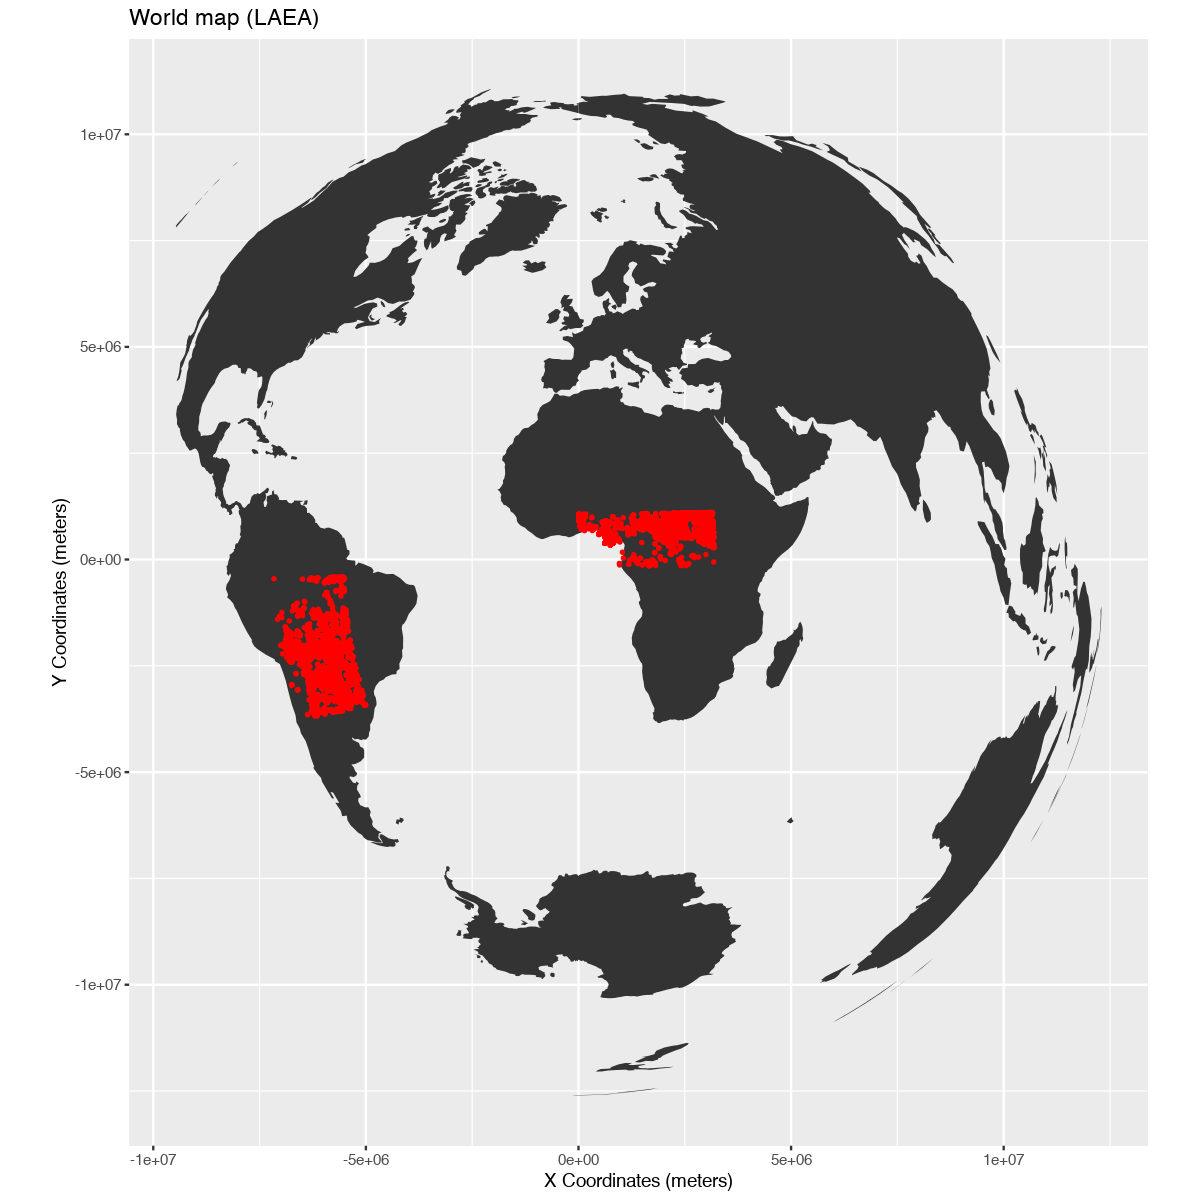

In [27]:
# Reproject in equal-area coordinate system to get area values
world.laea <- spTransform(world,CRS("+proj=laea"))
areas.laea <- spTransform(areas,CRS("+proj=laea"))
fire.laea <- spTransform(fire.pol.q, CRSobj = CRS("+proj=laea"))

# convert world and fire to dataframes
world.laea_df <- fortify(world.laea)
coord.fire <- as.data.frame(coordinates(fire.laea))

# Map fires in equal-area reference system
WorldMap.laea  <- ggplot(world.laea_df, aes(long,lat, group = group)) +
  geom_polygon() +
  labs(title = "World map (LAEA)",
       x = "X Coordinates (meters)",
       y = "Y Coordinates (meters)") +
  coord_equal()

# plot
WorldMap.laea +
geom_point(data=coord.fire,aes(x=coords.x1,y=coords.x2,group=NULL),size=0.5,col="red")

### - Calculate the total area of polygons 

In [28]:
# Calculate area with different methods (all final values in km^2)

# with original lat-long data (in decimal degrees)
# 1 decimal degree = 111.32 km
round(sapply(slot(areas, "polygons"), function(x) sapply(slot(x, "Polygons"), slot, "area"))*111.32^2,2)

# with laea projection
round(sapply(slot(areas.laea, "polygons"), function(x) sapply(slot(x, "Polygons"), slot, "area"))*10^-6,2)

# with internal conversion from lat-long to laea projection (geosphere)
round(areaPolygon(areas)*10^-6,2) #km^2  # geosphere package
round(area(areas)*10^-6,2) #km^2  # raster package
             
# The differences in calculation methods are important to consider in smaller scale operations.
# The options from package raster and geosphere give the same result
# and they have the advantage that reprojecting the data is not necessary

[1] 5654233 3967170

[1] 5253469 3936621

[1] 5391806 4008290

[1] 5391806 4008290

### - Calculate the area of each country inside the study area

In [29]:
# Extract areas from polygon objects then attach as attribute
areas.country$area <- areaPolygon(areas.country)*10^-6 # in km^2
#head(areas.country)

# For each polygon of interest, get area by continent
# the values are a little bit different, especially for Africa, there were some points in the ocean
aggregate(area~region_un, data=areas.country, FUN=sum)

# For each polygon of interest, get area by country
aggregate(area~region_un + sovereignt, data=areas.country, FUN=sum)

region_un,area
<chr>,<dbl>
Africa,3164928
Americas,5368655


region_un,sovereignt,area
<chr>,<chr>,<dbl>
Americas,Argentina,732417.66
Africa,Benin,50632.56
Americas,Bolivia,1083011.74
Americas,Brazil,3025053.74
Africa,Cameroon,423651.27
Africa,Central African Republic,595551.78
Africa,Chad,112146.54
Americas,Chile,109208.65
Africa,Democratic Republic of the Congo,823792.21


### - Calculate fires per km2

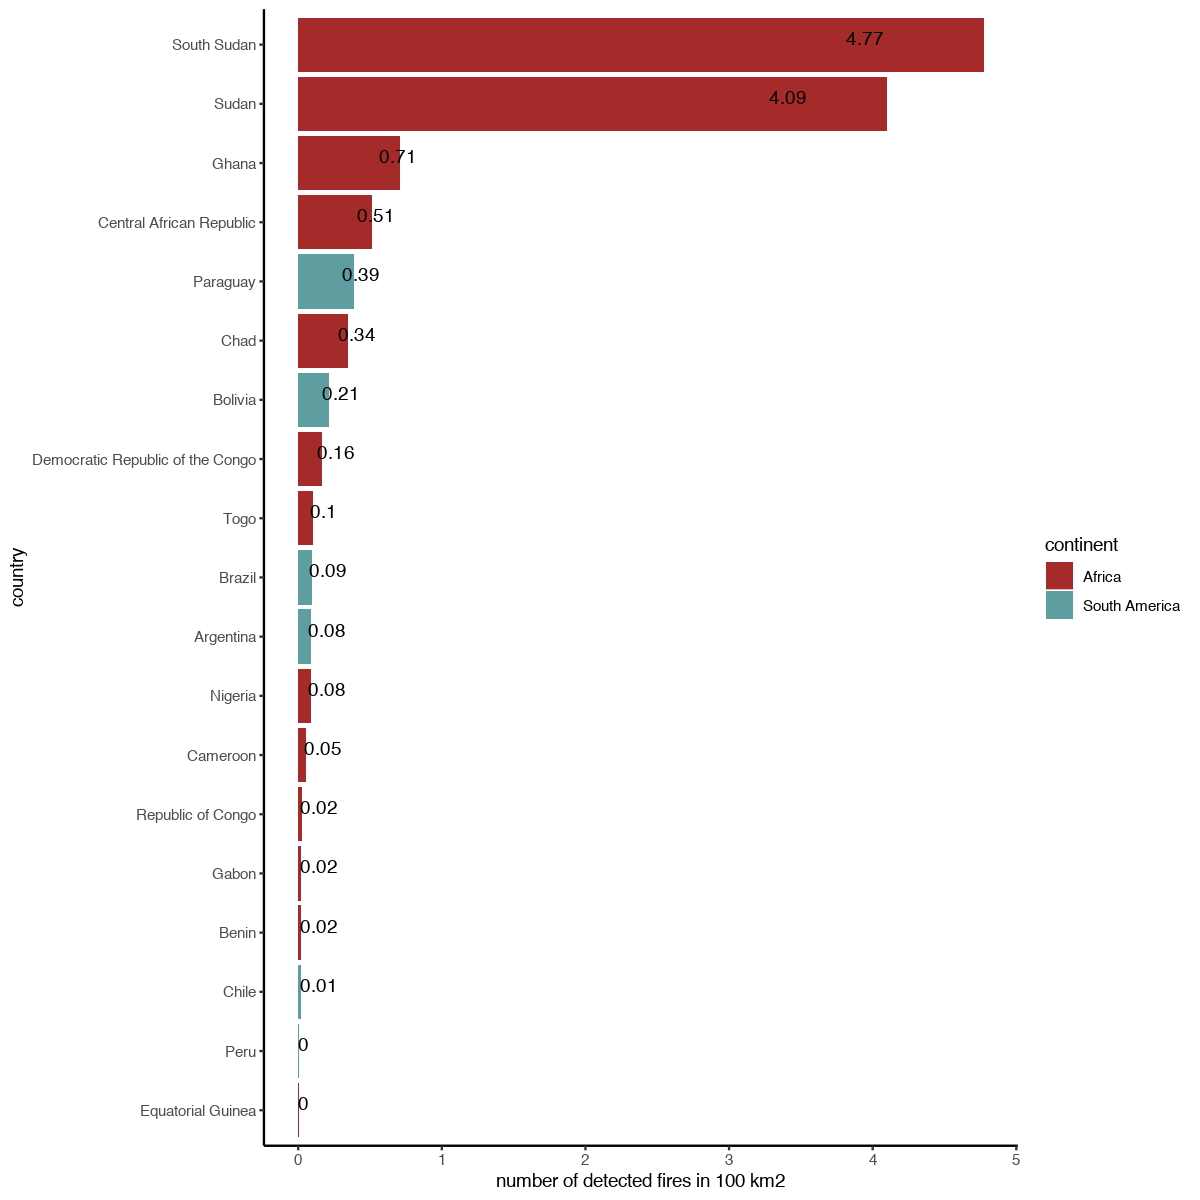

In [30]:
# Divide the number of fires in each country by the area of the country inside the polygon
areas.country@data$n.fires.area  <- areas.country@data$n.fires/areas.country@data$area

# Rank the countries by number of fires
ggplot(data=areas.country@data, aes(x=reorder(sovereignt,n.fires.area), y = n.fires.area*100, fill=continent)) +
geom_bar(stat='identity') + 
    coord_flip()+
    ylab('number of detected fires in 100 km2')+
    xlab('country')+
    geom_text(aes(y=n.fires.area*80,label = round(n.fires.area*100,2), 
                  vjust=0,hjust=0))+
    scale_fill_manual(values=c('brown','cadetblue'))+
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          panel.background = element_blank(), axis.line = element_line(colour = "black"))


#Notice the difference between this ranking and the one considering onl numer of fires by country

In [31]:
# Calculate if there are significant differences by continent
anova.fires  <- aov(n.fires.area ~ continent,data=areas.country@data)
summary(anova.fires)
# No significant differences in fires/km2

            Df    Sum Sq   Mean Sq F value Pr(>F)
continent    1 0.0002043 0.0002043   1.103  0.308
Residuals   17 0.0031473 0.0001851               

## 10. Fire evolution by day and country

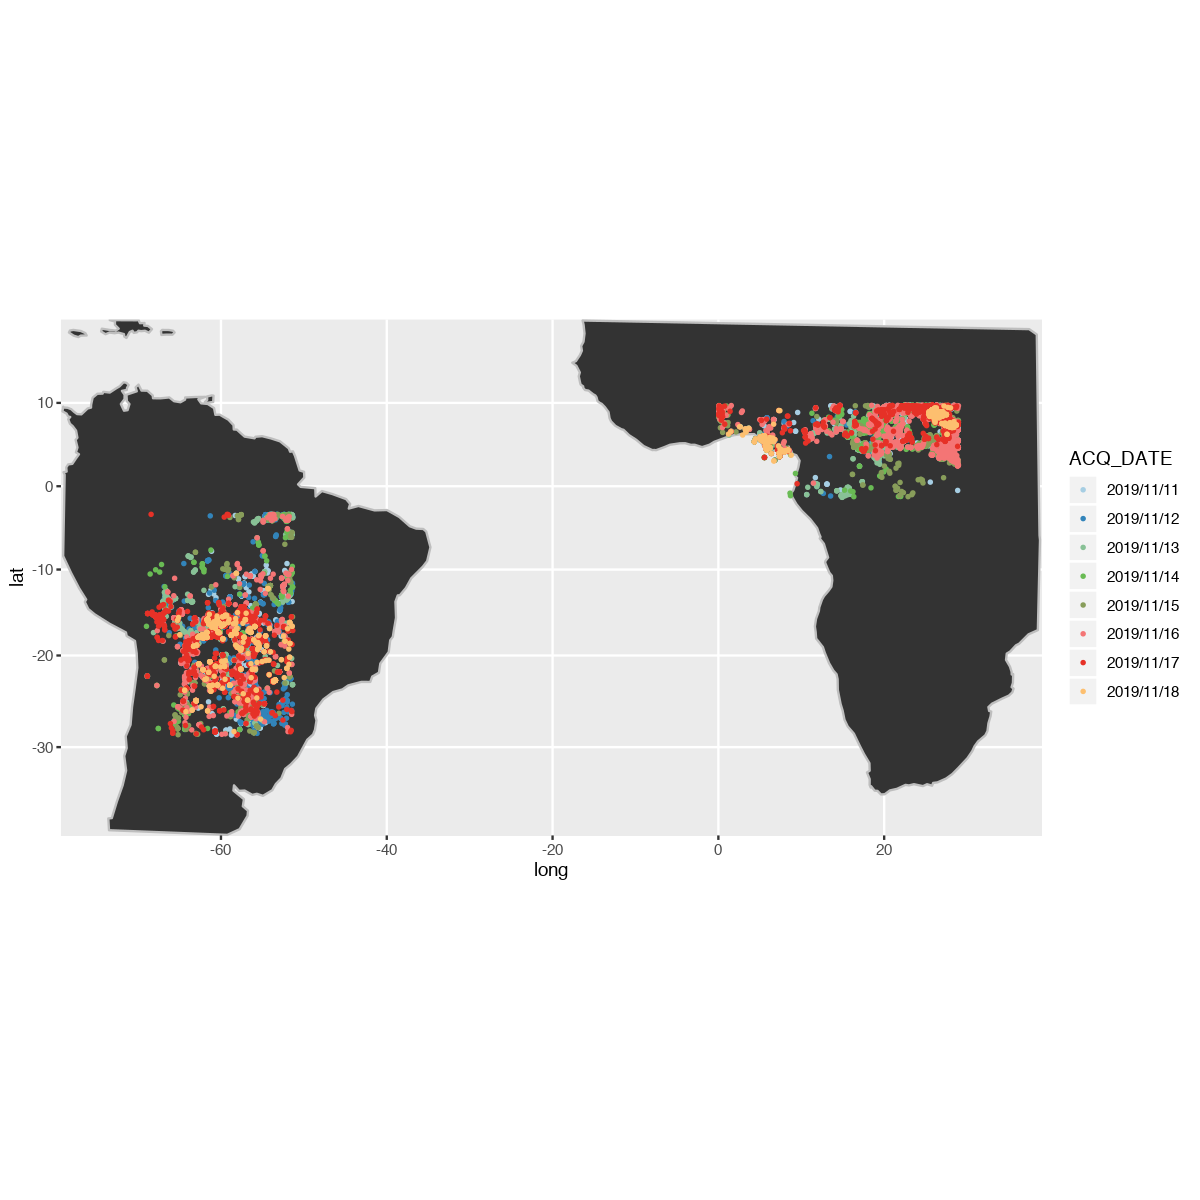

In [32]:
# Fires per day
# Prepare color palette for plot
rbPal <- colorRampPalette(brewer.pal(n = 7, name = "Paired"))
colday  <- rbPal(length(unique(fire.pol.q@data$ACQ_DATE)))

options(repr.plot.width=10, repr.plot.height=10)
smallMap + 
geom_point(data=fire.pol.q@data,aes(x=LONGITUDE,y=LATITUDE,group=NULL,color=ACQ_DATE),size=0.5) +
scale_color_manual(values=colday,aesthetics = "colour")+
borders("world", xlim = c(-130, -60), ylim = c(20, 50))

### - Fire evolution by day and country

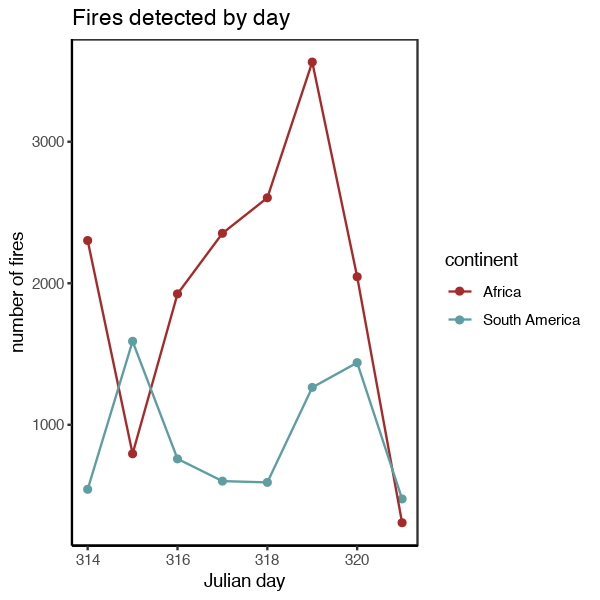

In [33]:
# calculate fires by day and country
fires.day  <- fire.country@data %>%
    group_by(continent,ACQ_DATE) %>% count()

# convert date to Julian day
fires.day$Jday  <- as.POSIXlt(fires.day$ACQ_DATE, format = "%Y/%m/%d")$yday

options(repr.plot.width=5, repr.plot.height=5)
ggplot(data=fires.day, aes(x=Jday, y=n, col=continent))+
    geom_point()+
    geom_line()+
    theme_bw()+
    theme(strip.text.y = element_text(angle = 0))+
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          axis.line = element_line(colour = "black"))+
    scale_color_manual(values=c('brown','cadetblue'))+
    labs(title = "Fires detected by day",
       x = "Julian day",
       y = "number of fires") 

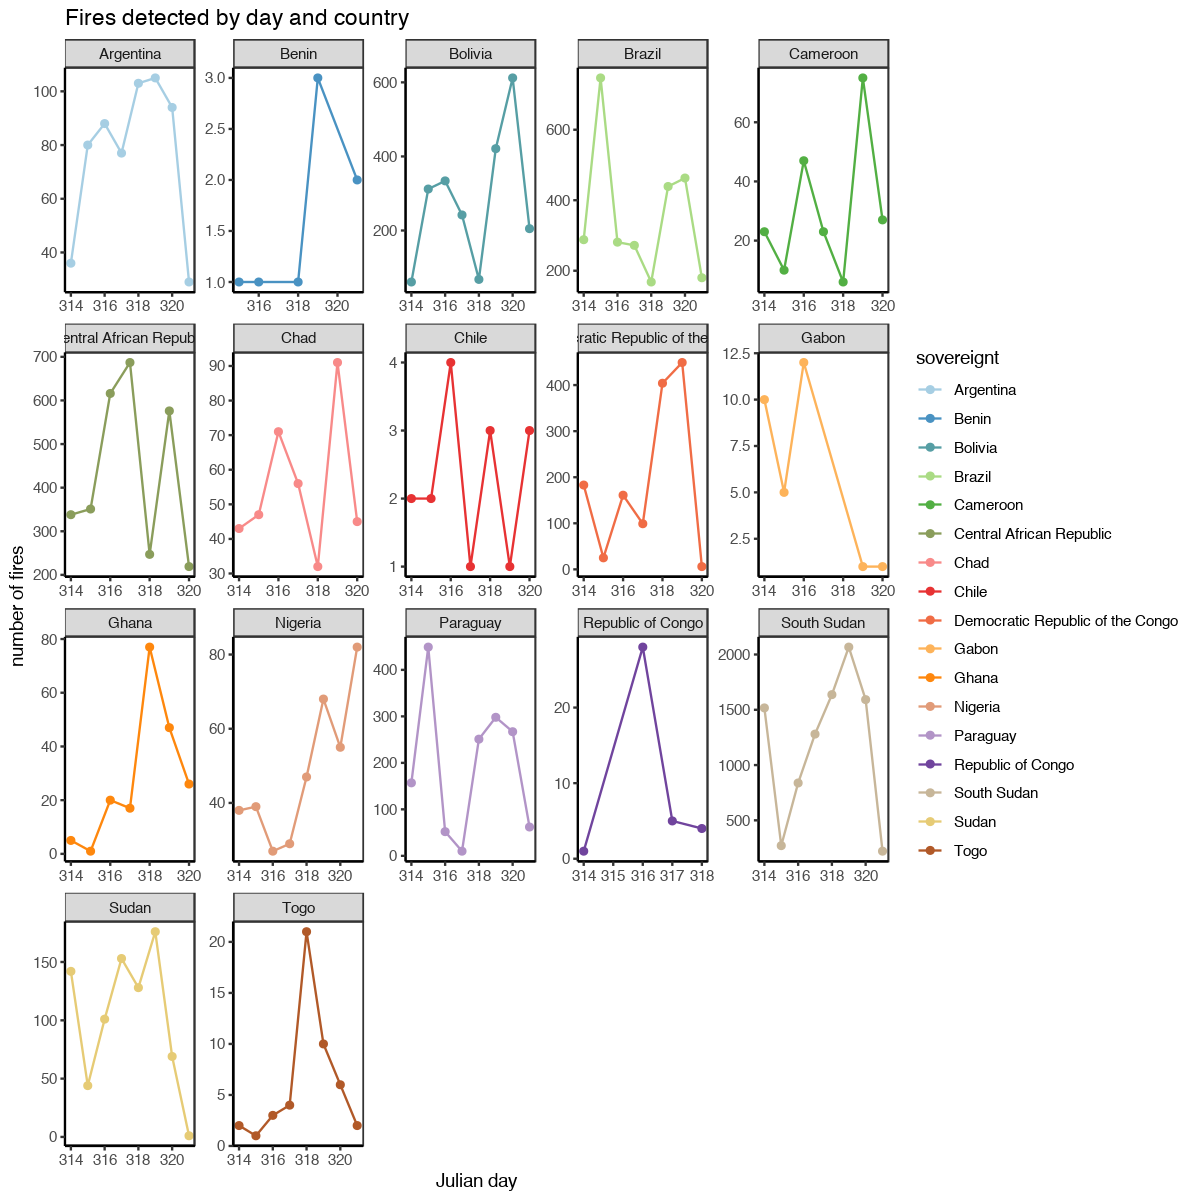

In [34]:
#head(fire.country)
# calculate fires by day and country
fires.day.country  <- fire.country@data %>%
    group_by(sovereignt,continent,ACQ_DATE) %>% count()

# convert date to Julian day
fires.day.country$Jday  <- as.POSIXlt(fires.day.country$ACQ_DATE, format = "%Y/%m/%d")$yday

# set colors
rbPal <- colorRampPalette(brewer.pal(n = 12, name = "Paired"))
colday  <- rbPal(length(unique(fires.day.country$sovereignt)))

# plot with free scales
options(repr.plot.width=10, repr.plot.height=10)
ggplot(data=fires.day.country, aes(x=Jday, y=n, col=sovereignt))+
    geom_point()+
    geom_line()+
    theme_bw()+
    facet_wrap(sovereignt~.,scales="free") +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          axis.line = element_line(colour = "black"))+
    theme(strip.text.y = element_text(angle = 0))+
    scale_color_manual(values=colday)+
    labs(title = "Fires detected by day and country",
       x = "Julian day",
       y = "number of fires") 

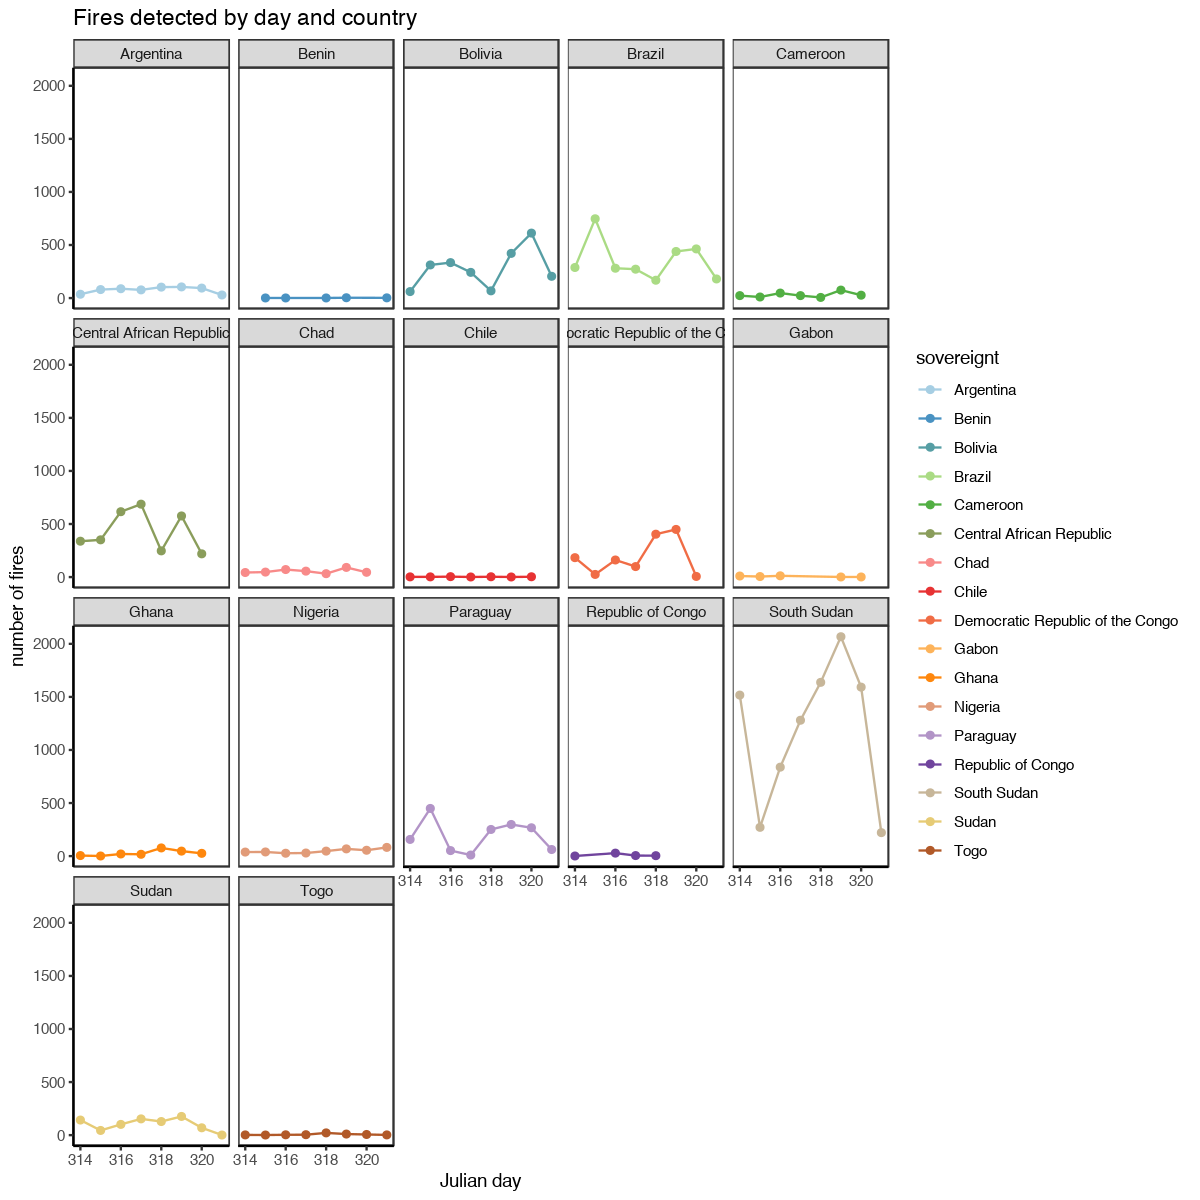

In [35]:
# plot with same scales
options(repr.plot.width=10, repr.plot.height=10)
ggplot(data=fires.day.country, aes(x=Jday, y=n, col=sovereignt))+
    geom_point()+
    geom_line()+
    theme_bw()+
    facet_wrap(sovereignt~.) +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          axis.line = element_line(colour = "black"))+
    theme(strip.text.y = element_text(angle = 0))+
    scale_color_manual(values=colday)+
    labs(title = "Fires detected by day and country",
       x = "Julian day",
       y = "number of fires") 

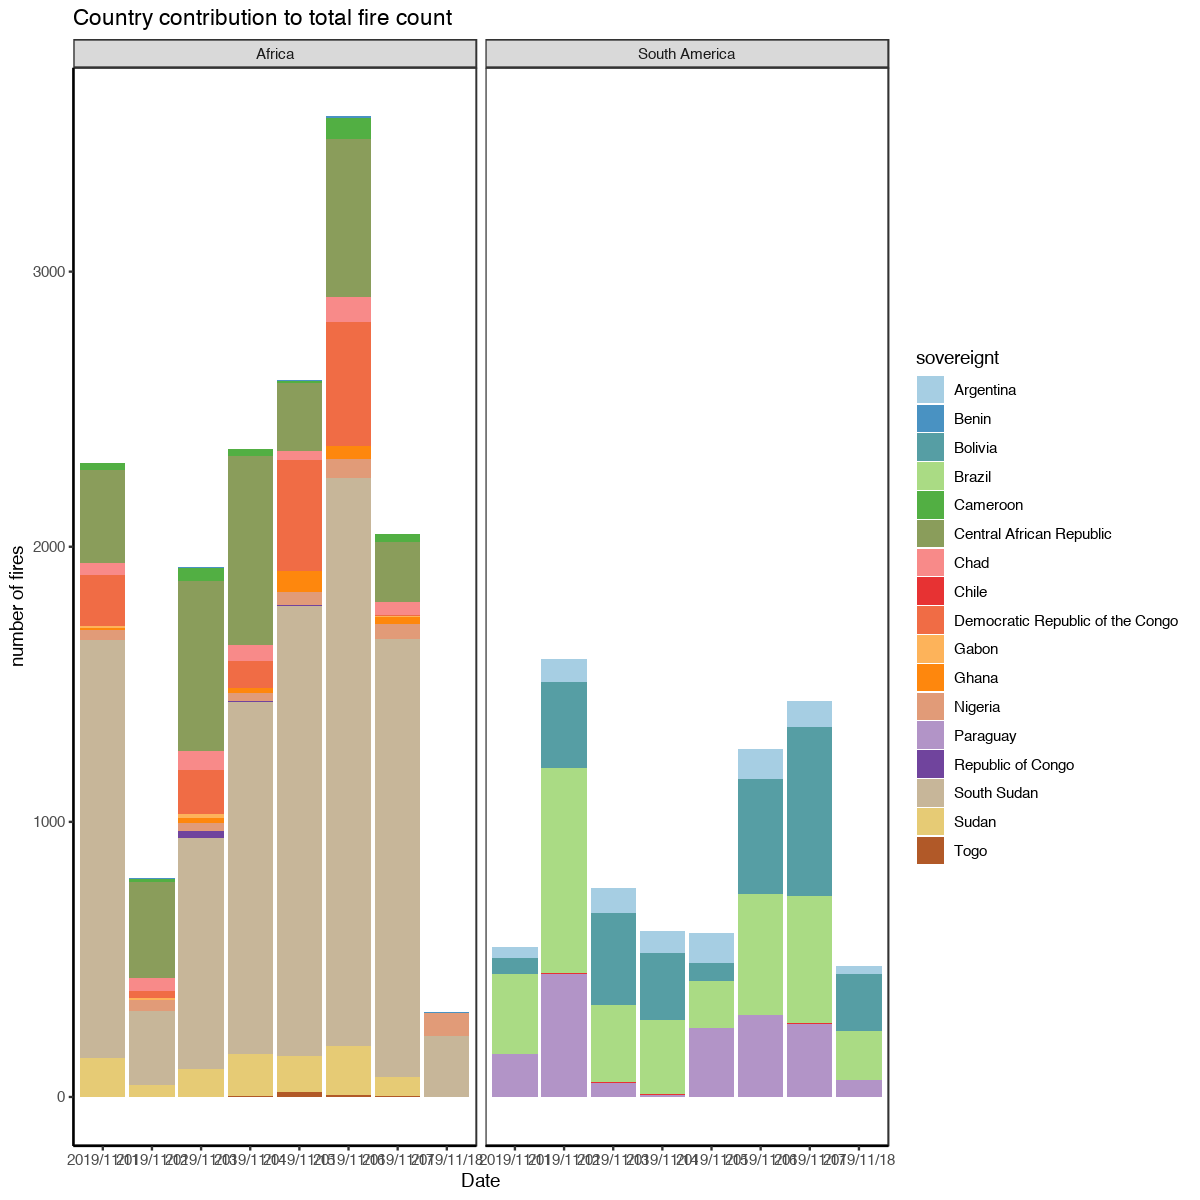

In [36]:
# Contribution of each country to the total count of fires
options(repr.plot.width=10, repr.plot.height=10)
ggplot(data=fires.day.country, aes(x=ACQ_DATE, y=n, fill=sovereignt))+
    geom_bar(position="stack",stat="identity")+
    theme_bw()+
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          axis.line = element_line(colour = "black"))+
    facet_grid(.~continent)+
    theme(strip.text.y = element_text(angle = 0))+
    scale_fill_manual(values=colday)+
labs(title = "Country contribution to total fire count",
       x = "Date",
       y = "number of fires") 

### South Sudan and Central African Republic are the major fire contributors in Africa 
### Brazil and Bolivia are the major fire contributors in South America

## 11. Detection of fires per terrestrial biome (over 7 days)

In [37]:
temp <- tempfile()
download.file("https://c402277.ssl.cf1.rackcdn.com/publications/15/files/original/official_teow.zip?1349272619",temp)
ecoregions <- unzip(temp)
unlink(temp)

# check the files in the unzipped folder
#ecoregions

# Load polygons of ecoregions and biomes of WWF 2012
eco <- readOGR("./official/wwf_terr_ecos.shp") 

OGR data source with driver: ESRI Shapefile 
Source: "/Users/huetestm/Documents/Vizzuality/official/wwf_terr_ecos.shp", layer: "wwf_terr_ecos"
with 14458 features
It has 21 fields


In [38]:
temp <- tempfile()
download.file("http://maps.tnc.org/files/shp/terr-ecoregions-TNC.zip",temp)
biomes <- unzip(temp)
unlink(temp)

# check the files in the unzipped folder
#biomes

# Load the biome names from another file
biome <- readOGR("./tnc_terr_ecoregions.shp") 

# Load the biome names from another file
#biome <- readOGR("terr-ecoregions-TNC","tnc_terr_ecoregions") ## get the biome names

OGR data source with driver: ESRI Shapefile 
Source: "/Users/huetestm/Documents/Vizzuality/tnc_terr_ecoregions.shp", layer: "tnc_terr_ecoregions"
with 814 features
It has 16 fields


In [39]:
crs(eco) # same coordinate system as fires (longlat, datum= WGS84)
head(eco)
#The variable of interest is BIOME (14 classified terrestrial biomes)
unique(eco$BIOME)

CRS arguments:
 +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0 

,OBJECTID,AREA,PERIMETER,ECO_NAME,REALM,BIOME,ECO_NUM,ECO_ID,ECO_SYM,GBL_STAT,⋯,G200_NUM,G200_BIOME,G200_STAT,Shape_Leng,Shape_Area,area_km2,eco_code,PER_area,PER_area_1,PER_area_2
,<int>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<dbl>,<dbl>,<dbl>
0,1,29.80294,0.219,Northern Mesoamerican Pacific mangroves,NT,14,4,61404,119,1,⋯,0,0,0,0.2194754,0.002768565,8174,NT1404,0,0,0
1,2,11.97782,0.193,Northern Mesoamerican Pacific mangroves,NT,14,4,61404,119,1,⋯,0,0,0,0.1932891,0.001111245,8174,NT1404,0,0,0
2,3,77301.37276,111.954,Sinaloan dry forests,NT,2,28,60228,98,1,⋯,56,2,1,111.9514139,6.879187826,77362,NT0228,0,0,0
3,4,215.48918,1.274,Northern Mesoamerican Pacific mangroves,NT,14,4,61404,119,1,⋯,0,0,0,1.2736542,0.019701467,8174,NT1404,0,0,0
4,5,19.63909,0.363,Northern Mesoamerican Pacific mangroves,NT,14,4,61404,119,1,⋯,0,0,0,0.3630683,0.001790948,8174,NT1404,0,0,0
5,6,19867.17470,14.323,Everglades,NT,9,4,60904,59,2,⋯,100,9,0,14.3227723,1.793283597,20028,NT0904,0,0,0


[1] 14  2  9  3  1 13  7 10  4  8  6 11  5 99 12 98

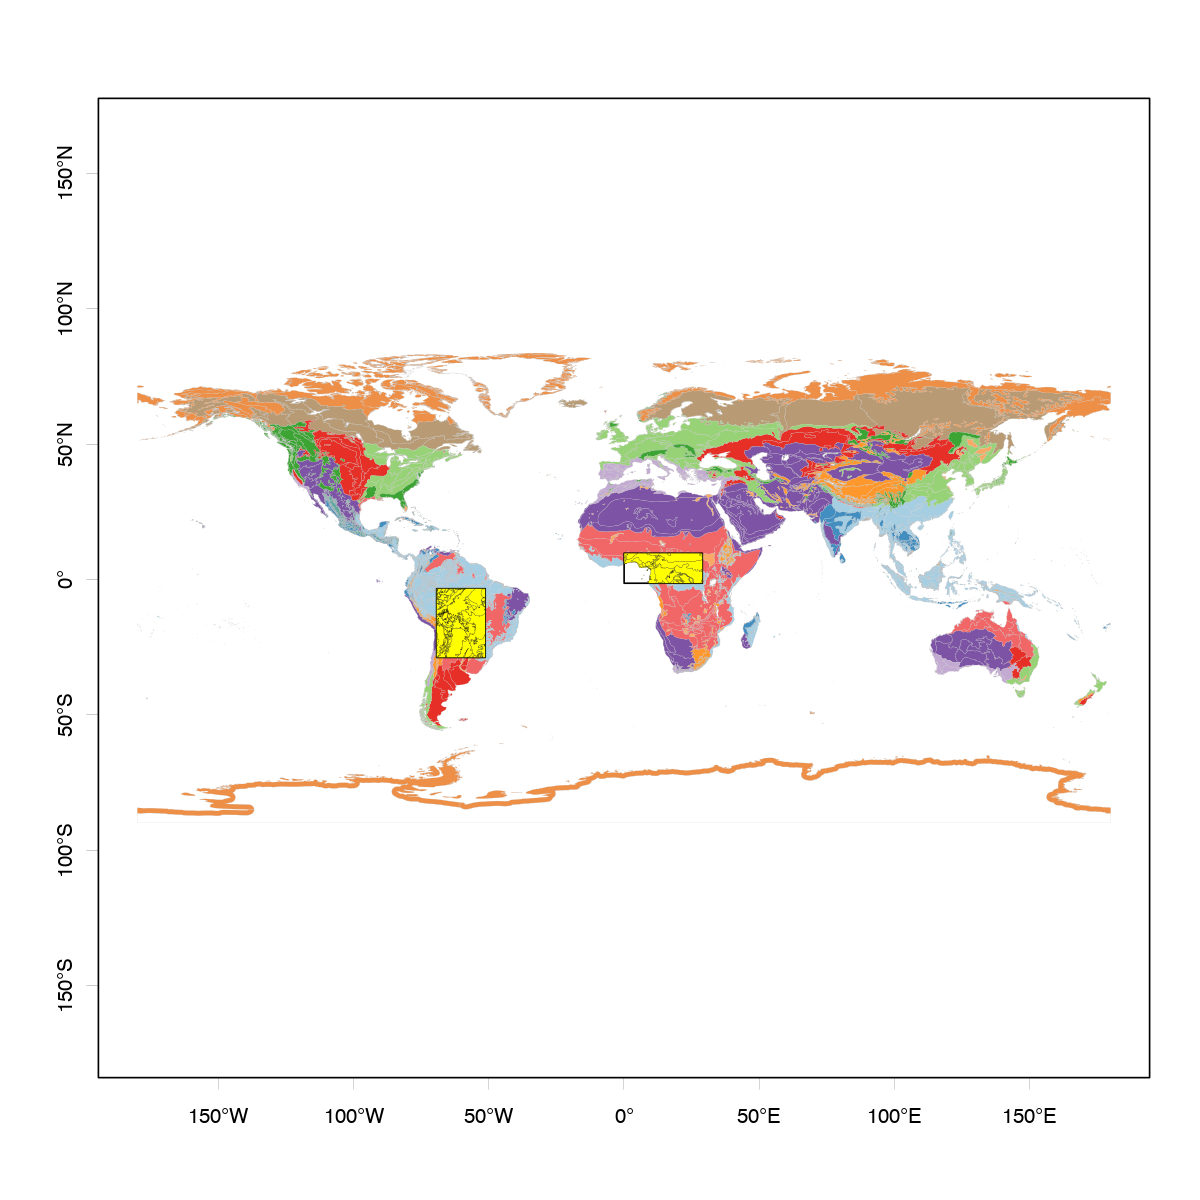

In [40]:
### Cross points from areas and biomes
areas.eco <- intersect(eco,areas)

# Prepare color palette for plot
rbPal <- colorRampPalette(brewer.pal(n = 12, name = "Paired"))
colBiome  <- rbPal(length(unique(eco$BIOME)))

# plot intersection of biomes and polygons
plot(eco, axes=T,col=colBiome[eco$BIOME],border='gray',lwd=0.1); 
plot(areas, add=T); 
plot(areas.eco, add=T, col='yellow',lwd=0.1)

In [41]:
length(unique(areas.eco$BIOME)) #fires are spread over 10 biomes

[1] 10

In [42]:
### cross fire points with the biomes
fire.eco  <- intersect(fire.pol.q,areas.eco)
head(fire.eco)
nrow(fire.eco) #23163 (less beacuse some points fall in sea)

,LATITUDE,LONGITUDE,BRIGHT_TI4,SCAN,TRACK,ACQ_DATE,ACQ_TIME,SATELLITE,CONFIDENCE,VERSION,⋯,G200_BIOME,G200_STAT,Shape_Leng,Shape_Area,area_km2,eco_code,PER_area,PER_area_1,PER_area_2,FID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<int>
434,9.69534,28.38891,329.0,0.57,0.52,2019/11/11,0006,N,nominal,1.0NRT,⋯,0,0,239.70902,253.68425,3042451,AT0713,0,0,0,1
435,9.69629,28.38371,309.0,0.57,0.52,2019/11/11,0006,N,nominal,1.0NRT,⋯,0,0,239.70902,253.68425,3042451,AT0713,0,0,0,1
471,9.63897,25.65905,300.1,0.57,0.43,2019/11/11,0006,N,nominal,1.0NRT,⋯,7,1,56.30243,51.93519,913702,AT0705,0,0,0,1
472,9.66081,25.50947,301.1,0.56,0.43,2019/11/11,0006,N,nominal,1.0NRT,⋯,7,1,56.30243,51.93519,913702,AT0705,0,0,0,1
473,9.62099,25.64487,310.6,0.57,0.43,2019/11/11,0006,N,nominal,1.0NRT,⋯,7,1,56.30243,51.93519,913702,AT0705,0,0,0,1
474,9.62006,25.65016,315.0,0.57,0.43,2019/11/11,0006,N,nominal,1.0NRT,⋯,7,1,56.30243,51.93519,913702,AT0705,0,0,0,1


[1] 23169

In [43]:
#use biome file to get the names of the 14 biomes
#unique(biome$WWF_MHTNUM)
#unique(biome$WWF_MHTNAM)
biome.name  <- data.frame(BIOME = unique(biome$WWF_MHTNUM),
                          WWF_MHTNAM = NA)
for (i in unique(biome$WWF_MHTNUM)){
   biome.name[biome.name$BIOME==i,]$WWF_MHTNAM <- as.character(unique(biome[biome$WWF_MHTNUM==i,]$WWF_MHTNAM))
}
biome.name

BIOME,WWF_MHTNAM
<int>,<chr>
1,Tropical and Subtropical Moist Broadleaf Forests
2,Tropical and Subtropical Dry Broadleaf Forests
4,Temperate Broadleaf and Mixed Forests
7,"Tropical and Subtropical Grasslands, Savannas and Shrublands"
8,"Temperate Grasslands, Savannas and Shrublands"
10,Montane Grasslands and Shrublands
11,Tundra
14,Mangroves
9,Flooded Grasslands and Savannas


In [44]:
### Get the number of fires for each BIOME
areas.eco@data$n.fires  <- rep(0,nrow(areas.eco))
for (i in unique(areas.eco$BIOME)){
   areas.eco@data[areas.eco@data$BIOME==i,]$n.fires  <- nrow(fire.eco[fire.eco$BIOME==i,])
   }

In [45]:
### join biome names and areas.eco table
areas.eco@data  <- areas.eco@data %>% inner_join(biome.name, by='BIOME')
head(areas.eco)

OBJECTID,AREA,PERIMETER,ECO_NAME,REALM,BIOME,ECO_NUM,ECO_ID,ECO_SYM,GBL_STAT,⋯,Shape_Leng,Shape_Area,area_km2,eco_code,PER_area,PER_area_1,PER_area_2,FID,n.fires,WWF_MHTNAM
<int>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>
1804,469876.5675,86.458,Uatuma-Trombetas moist forests,NT,1,73,60173,245,3,⋯,86.454513,38.1825465,470048,NT0173,0,0,0,0,2684,Tropical and Subtropical Moist Broadleaf Forests
2926,104903.4859,18.787,Atacama desert,NT,13,3,61303,107,2,⋯,18.786639,9.2008603,104903,NT1303,0,0,0,0,12,Deserts and Xeric Shrublands
2929,578.1726,1.468,Pantanal,NT,9,7,60907,55,1,⋯,1.467973,0.0495629,170501,NT0907,0,0,0,0,854,Flooded Grasslands and Savannas
2930,13520.9281,10.257,Southern Andean Yungas,NT,1,65,60165,64,2,⋯,10.256180,1.1667181,75150,NT0165,0,0,0,0,2684,Tropical and Subtropical Moist Broadleaf Forests
2932,26086.7175,23.124,Bolivian montane dry forests,NT,2,6,60206,90,1,⋯,23.123551,2.2585667,72780,NT0206,0,0,0,0,1580,Tropical and Subtropical Dry Broadleaf Forests
2940,2520.5946,3.173,Southern Andean Yungas,NT,1,65,60165,64,2,⋯,3.172507,0.2185710,75150,NT0165,0,0,0,0,2684,Tropical and Subtropical Moist Broadleaf Forests


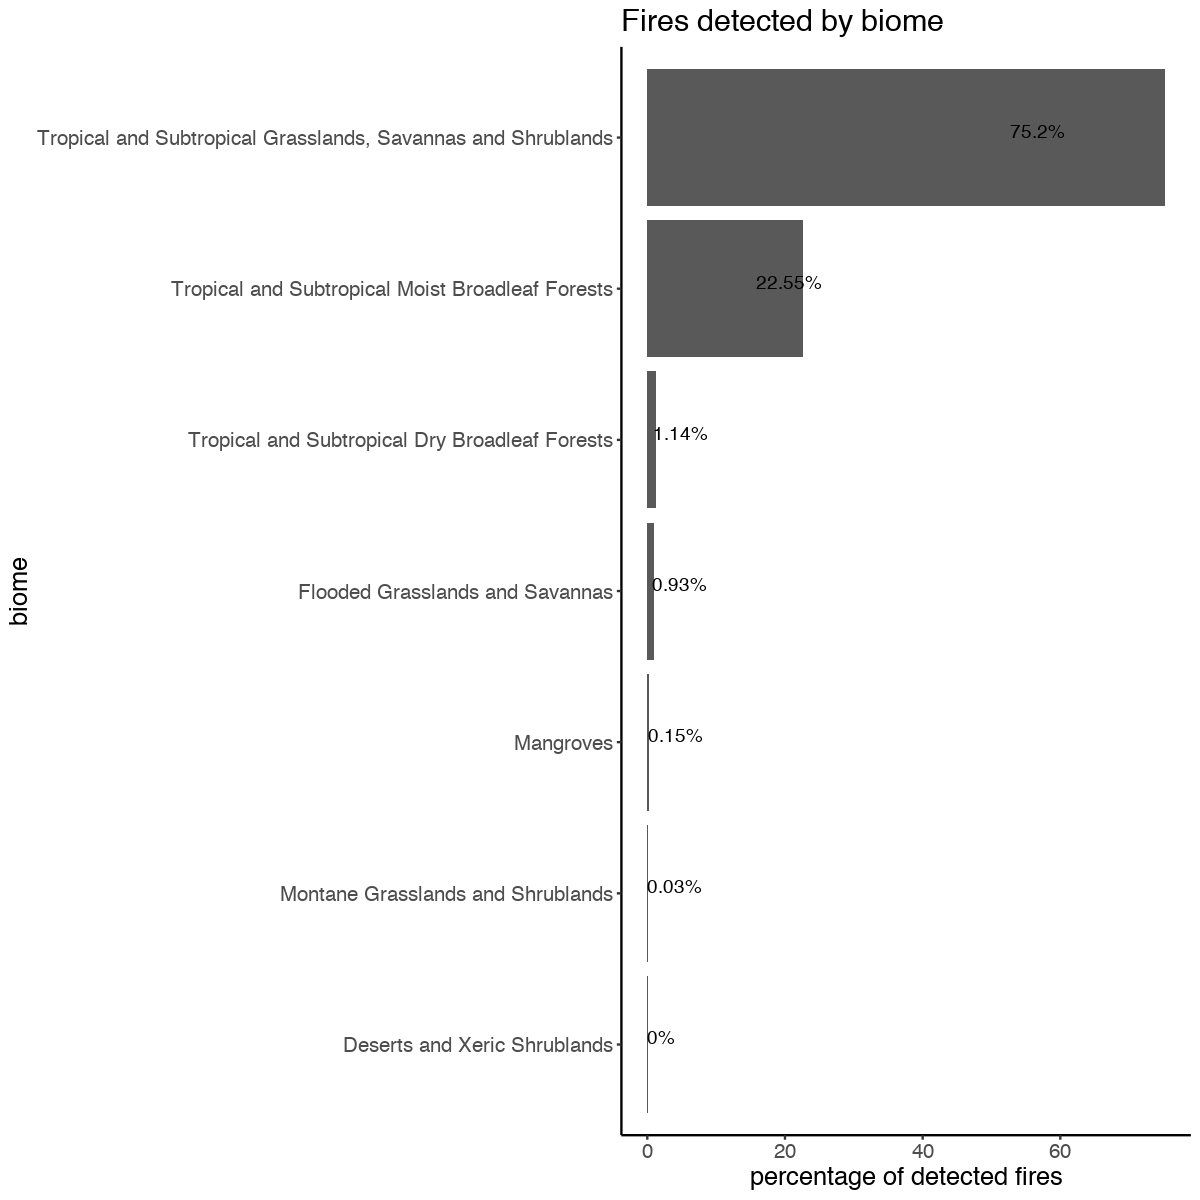

In [46]:
### percentage of fires in each biome
areas.eco@data %>% 
    filter(n.fires > 1) %>%
    group_by(n.fires,WWF_MHTNAM) %>%
    summarise(total.fires = sum(n.fires)) %>%
    ungroup() %>%
    mutate(per.fires = total.fires/sum(total.fires)*100) %>%
ggplot(aes(x=reorder(WWF_MHTNAM,per.fires), y = per.fires)) +
    geom_bar(stat='identity') + 
    coord_flip()+
    ylab('percentage of detected fires')+
    xlab('biome') +
    geom_text(aes(y=per.fires*0.7,label = paste(round(per.fires,2),'%',sep=""), 
                  vjust=0,hjust=0))+
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          panel.background = element_blank(),axis.line = element_line(colour = "black"),
          text = element_text(size=15))+
    labs(title = "Fires detected by biome") 

## 12. Summary of results
1. All fires detected are below 400K. This may indicate that fires are in cooling stage or are small
2. The temperature of fires is 4K higher in Africa than in South America
3. But the mass loss rate (and FRP) is higher in South America, 0.8 kg s-1
4. The absolute number of fires is greatest in South Sudan and Central African Republic for Africa, and Brazil and Bolivia for South America
5. However, the relative number of fires normalized to country area inside the polygon, is greatest in South Sudan and Sudan for Africa, and Paraguay and Bolivia for South America.
6. The evolution of fires per day shows a great increase in the fires of South Sudan until the 17/11/2019
7. 75% of the burnt areas correspond to the biome type "Tropical and Subtropical Grasslands, Savannas and Shrublands" followed by "Tropical and Subtropical Moist Broadleaf Forests" (22%)

### Sources of inspiration and data
#### https://viirsland.gsfc.nasa.gov/PDF/VIIRS_activefire_375m_ATBD.pdf
#### https://datacarpentry.org/r-raster-vector-geospatial/
#### https://stackoverflow.com/questions/3647744/intersecting-points-and-polygons-in-r
#### https://www.earthdatascience.org/courses/earth-analytics/spatial-data-r/shapefile-structure/
#### https://gis.stackexchange.com/questions/133625/checking-if-points-fall-within-polygon-shapefile
#### https://rdrr.io/cran/rnaturalearth/man/ne_countries.html
#### https://gis.stackexchange.com/questions/140504/extracting-intersection-areas-in-r
#### http://rstudio-pubs-static.s3.amazonaws.com/84577_d3eb8b4712b64dbdb810773578d3c726.html
#### https://gis.stackexchange.com/questions/63793/how-to-overlay-a-polygon-over-spatialpointsdataframe-and-preserving-the-spdf-dat
#### https://geocompr.robinlovelace.net/reproj-geo-data.html
#### http://www.geo.hunter.cuny.edu/~jochen/gtech201/lectures/lec6concepts/map%20coordinate%20systems/how%20to%20choose%20a%20projection.htm
#### http://maps.tnc.org/files/metadata/TerrEcos.xml
#### https://www.worldwildlife.org/publications/terrestrial-ecoregions-of-the-world